In [86]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.function_base import average, median
import soundfile as sf
from scipy import signal
from scipy.io import wavfile

# Input file
INPUT_FILE = "../audio/xdousa00.wav"

# Frames
FRAME_SIZE = 1024
FRAME_OVERLAP = 512

# Filter params
PASS_LOSS = 3
BLOCK_ATT = 45
BAND_STOP_WIDTH = 30
BAND_DESCEND_WIDTH = 50

frame_shift = FRAME_SIZE - FRAME_OVERLAP

length: 14132 with sample rate 16000Hz (0.88325s)
Stats:
Max: 0.083709716796875, Min: -0.050750732421875, Avg: -1.1360952343307741e-05, Mean: -1.1360952343307741e-05, Med: -9.1552734375e-05


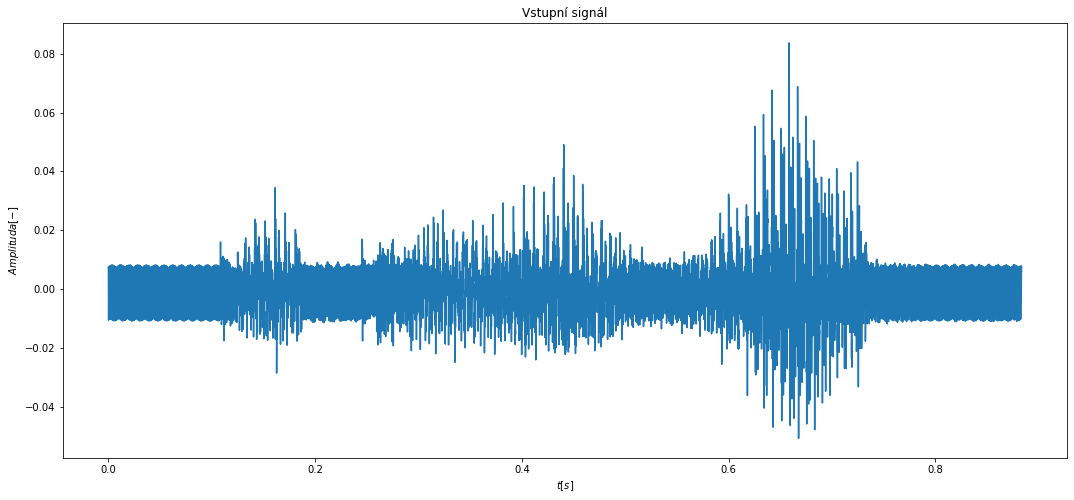

In [87]:
samples_orig, sample_freq = sf.read(INPUT_FILE)
orig_length_in_secs = samples_orig.size / sample_freq

print(f"length: {samples_orig.size} with sample rate {sample_freq}Hz ({orig_length_in_secs}s)")

print(f"Stats:\nMax: {max(samples_orig)}, Min: {min(samples_orig)}, Avg: {average(samples_orig)}, Mean: {np.mean(samples_orig)}, Med: {median(samples_orig)}")

time_to_index_coef = samples_orig.size / orig_length_in_secs

# Show input signal
plt.figure(figsize=(18,8))
plt.title("Vstupní signál")
plt.plot(np.arange(samples_orig.size) / sample_freq, samples_orig)
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_ylabel('$Amplituda[-]$')
plt.show()

In [88]:
def normalization(samples):
    # Centering
    samples_normal = samples - np.mean(samples)
    
    max_abs_val = max(abs(samples_normal))

    # Normalization
    samples_normal /= max_abs_val
    return samples_normal

Normalization

[ 0.0883483   0.07704834 -0.0169965  ...  0.03184849  0.09381602
  0.07012256]
Stats:
Max: 1.0, Min: -0.606052535796524, Avg: 1.5122978505543633e-18, Mean: 1.5122978505543633e-18, Med: -0.0009578445976520053


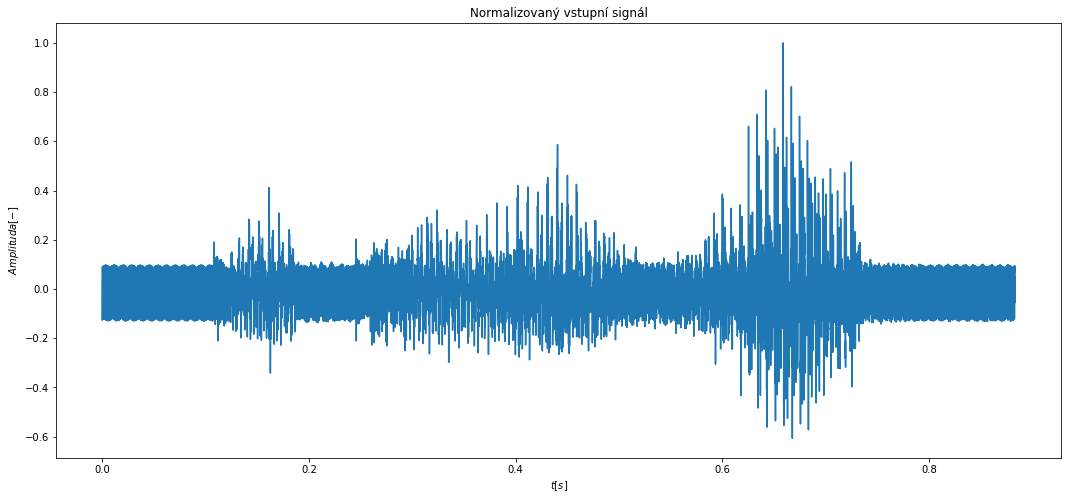

In [89]:
samples_normal = normalization(samples_orig)
print(samples_normal)

print(f"Stats:\nMax: {max(samples_normal)}, Min: {min(samples_normal)}, Avg: {average(samples_normal)}, Mean: {np.mean(samples_normal)}, Med: {median(samples_normal)}")

# Show normalized and centered signal
plt.figure(figsize=(18,8))
plt.title("Normalizovaný vstupní signál")
plt.plot(np.arange(samples_orig.size) / sample_freq, samples_normal)
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_ylabel('$Amplituda[-]$')
plt.show()

Frames

In [90]:
number_of_frames = samples_normal.size // frame_shift
frames = [samples_normal[idx * frame_shift : FRAME_SIZE + idx * frame_shift] for idx in range(number_of_frames)]

frames = []
for idx in range(number_of_frames):
  frames.append(samples_normal[idx * frame_shift : FRAME_SIZE + idx * frame_shift])

# Pad last frame with zeroes
frames[len(frames) - 1] = np.pad(frames[len(frames) - 1], (0, FRAME_SIZE - frames[len(frames) - 1].shape[0]), "constant")

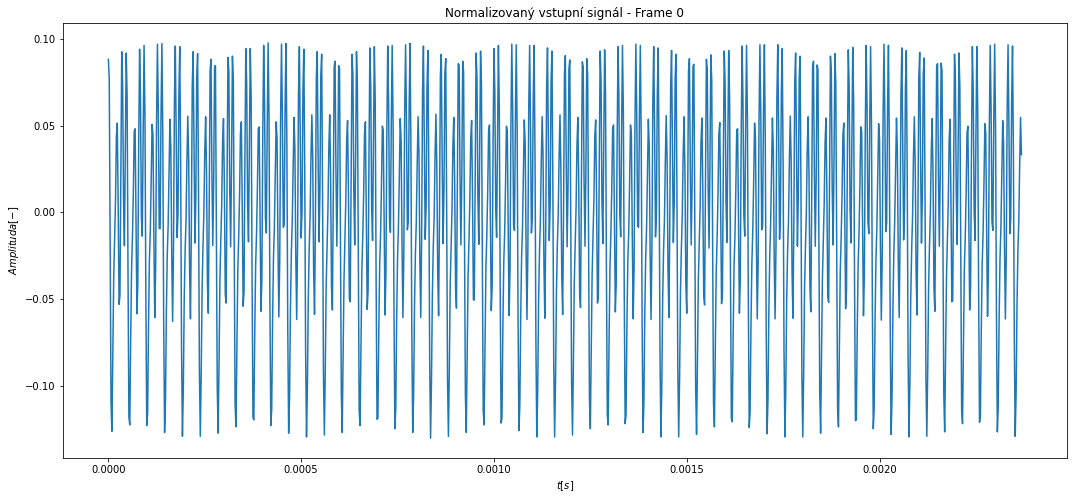

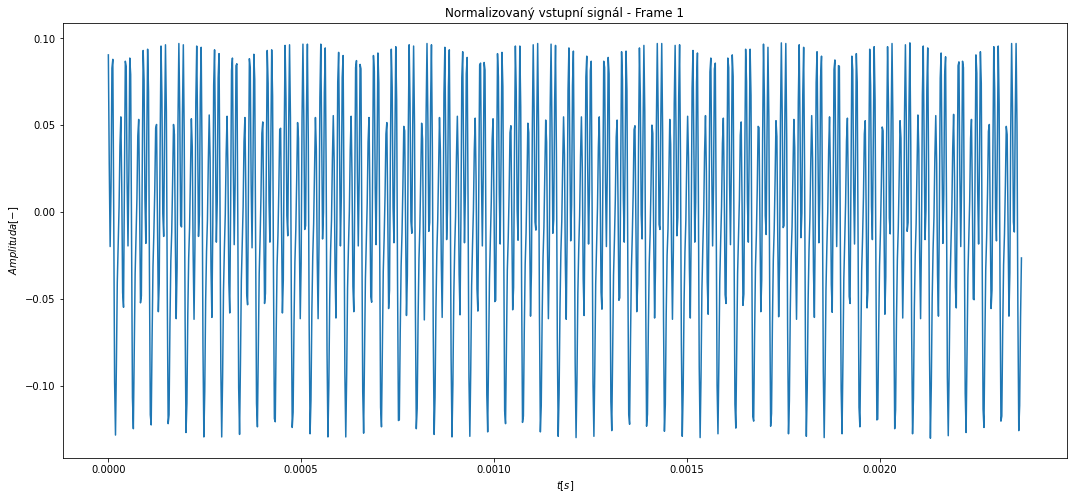

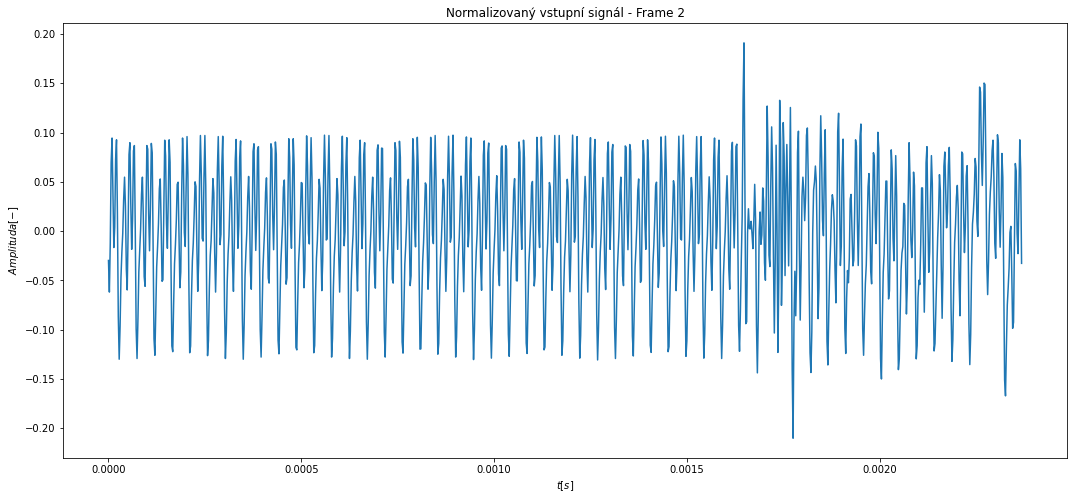

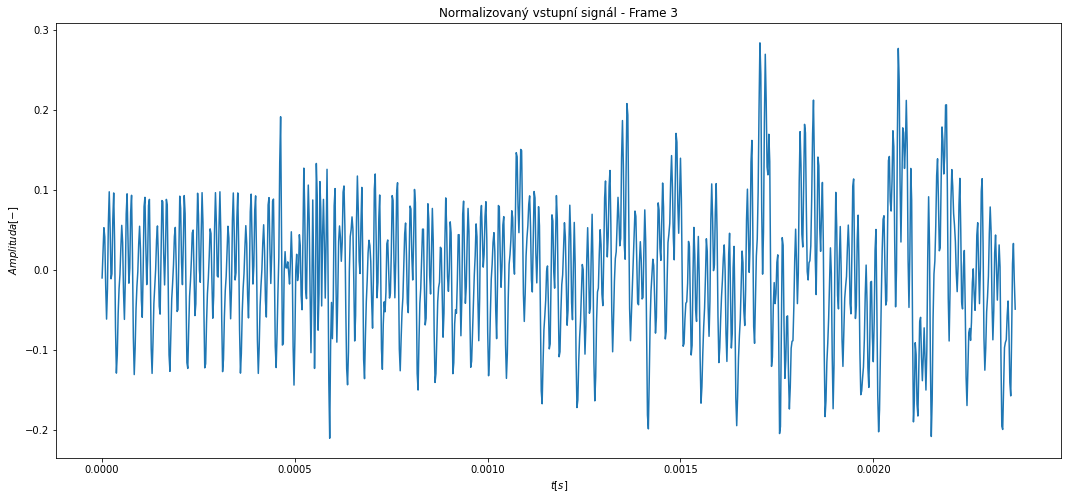

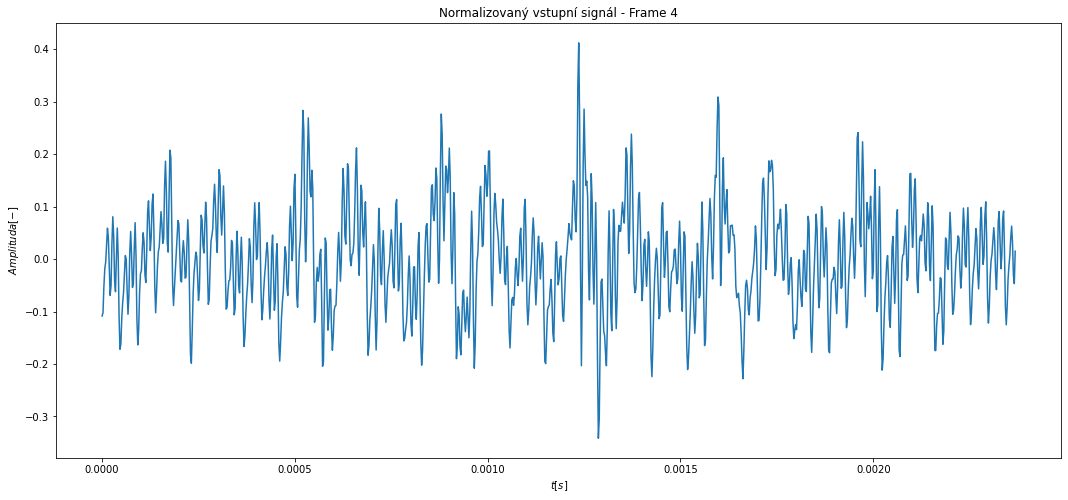

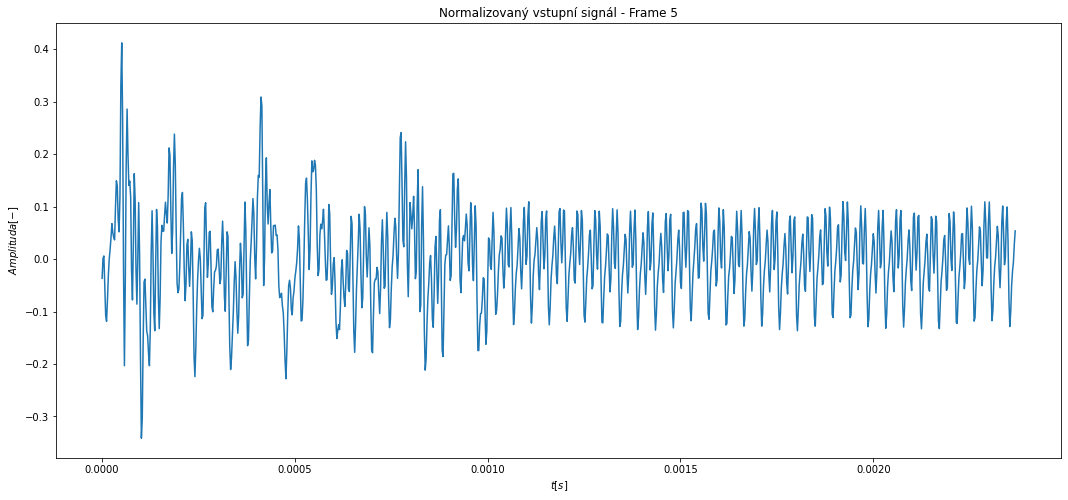

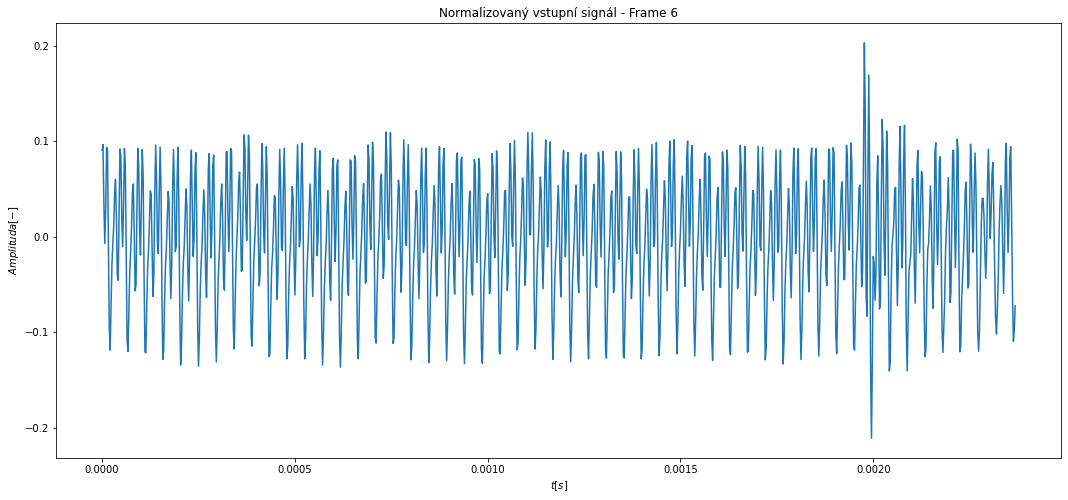

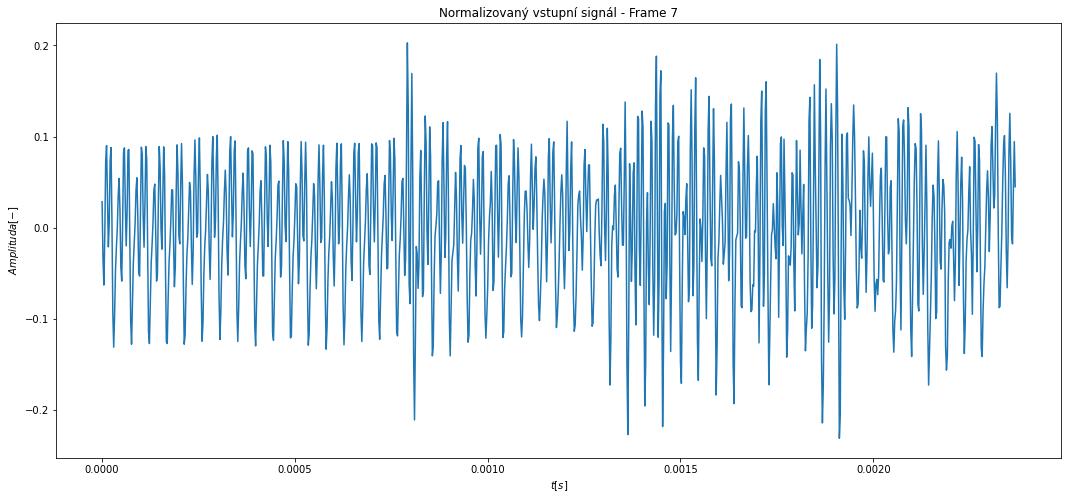

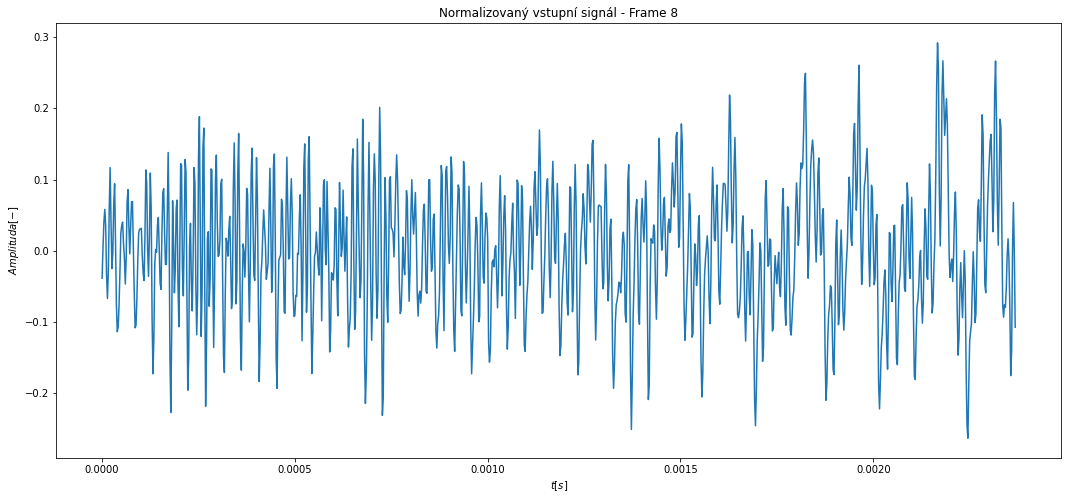

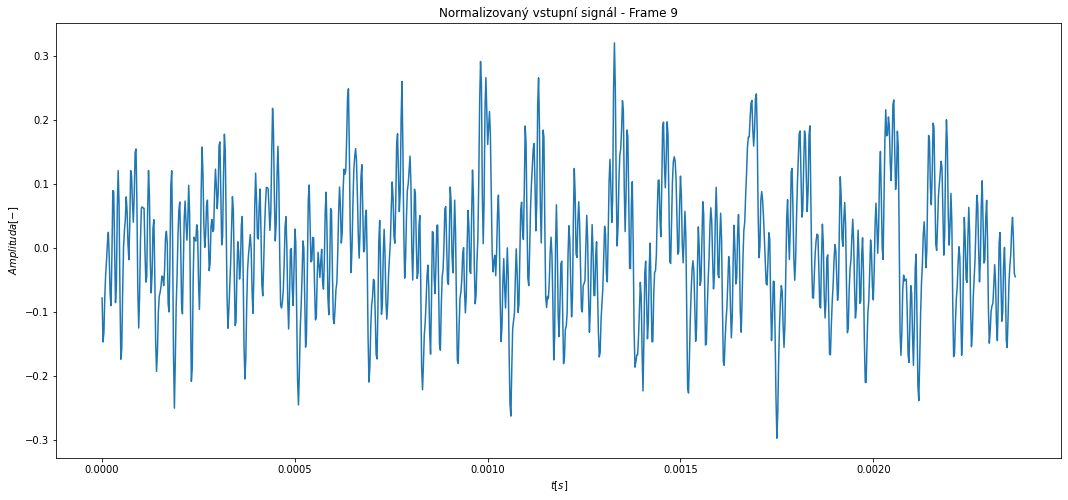

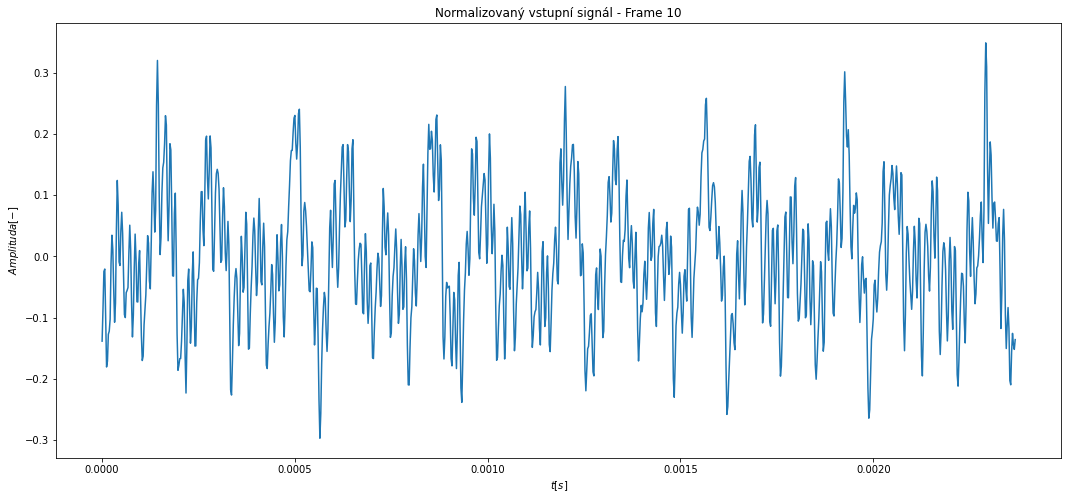

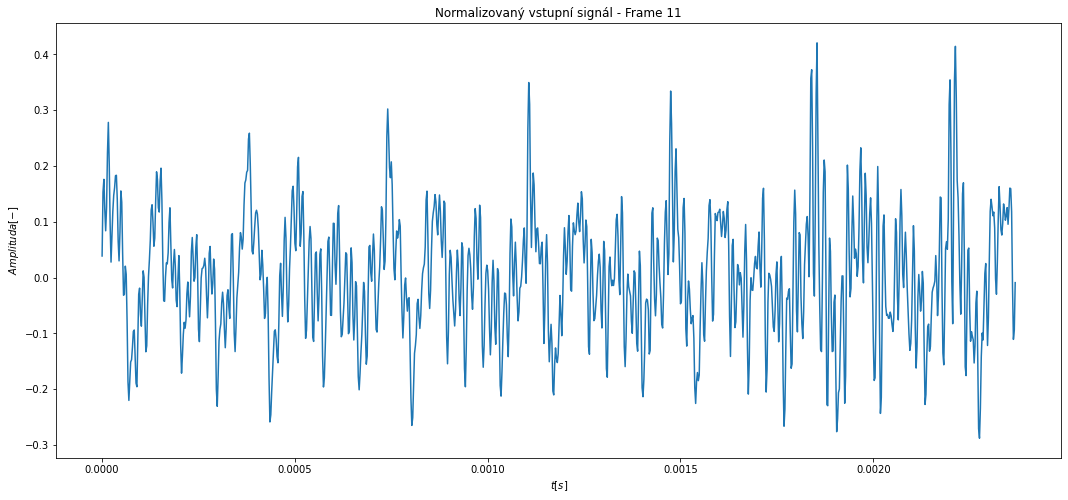

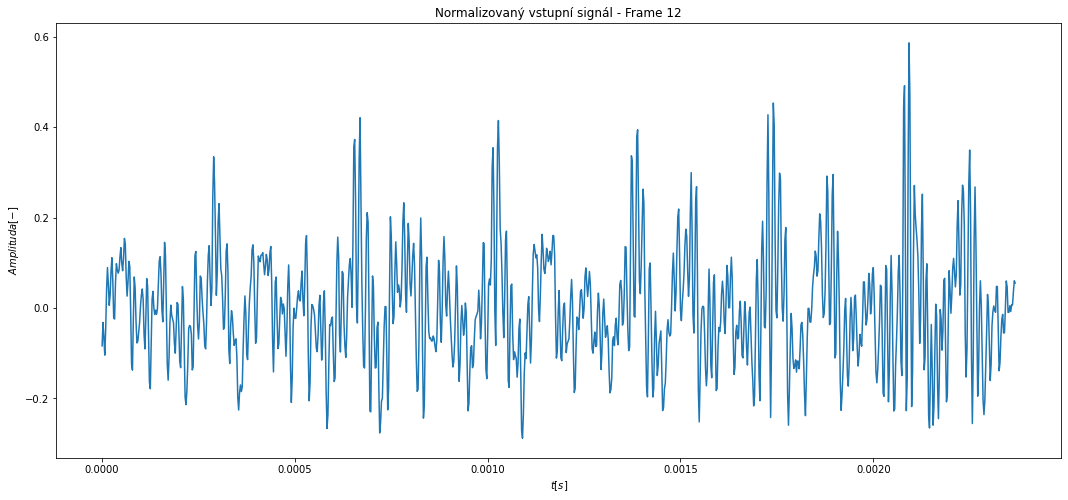

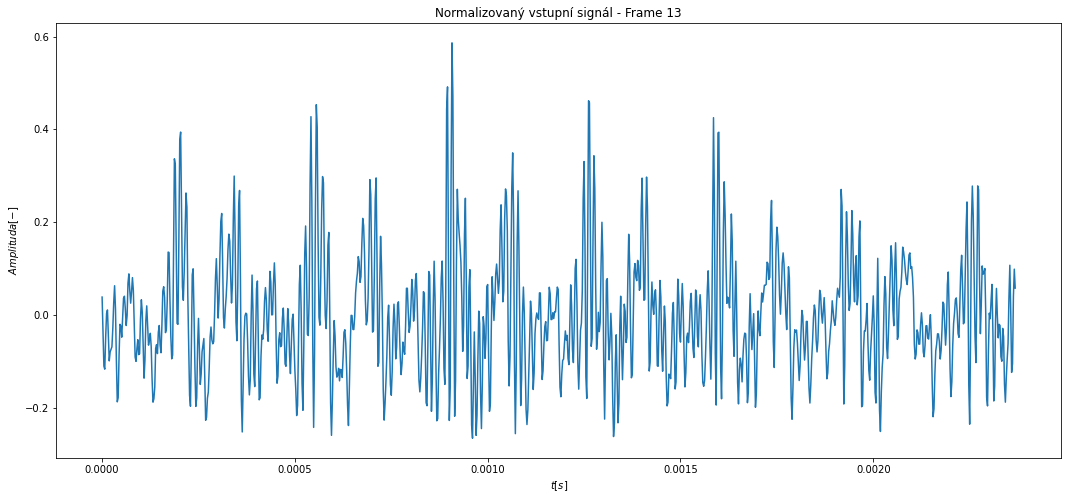

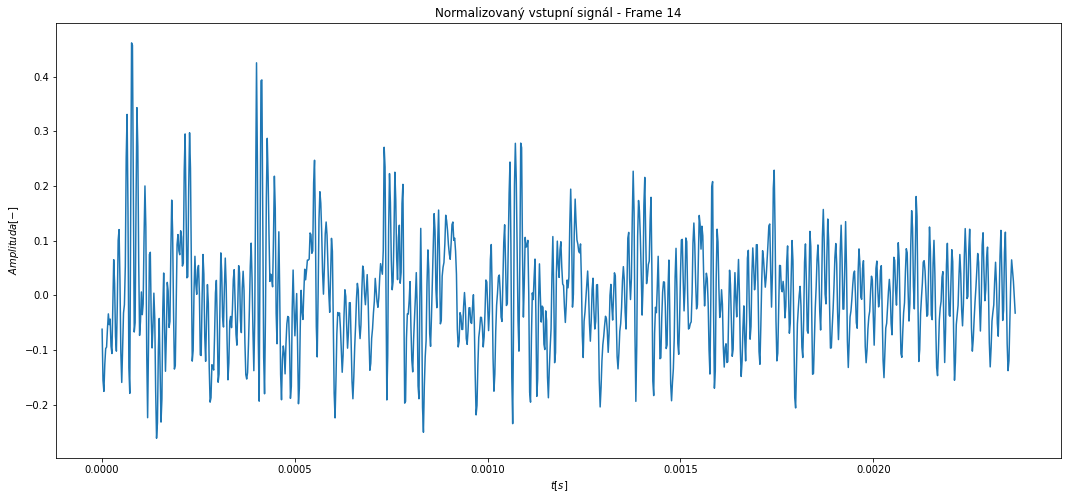

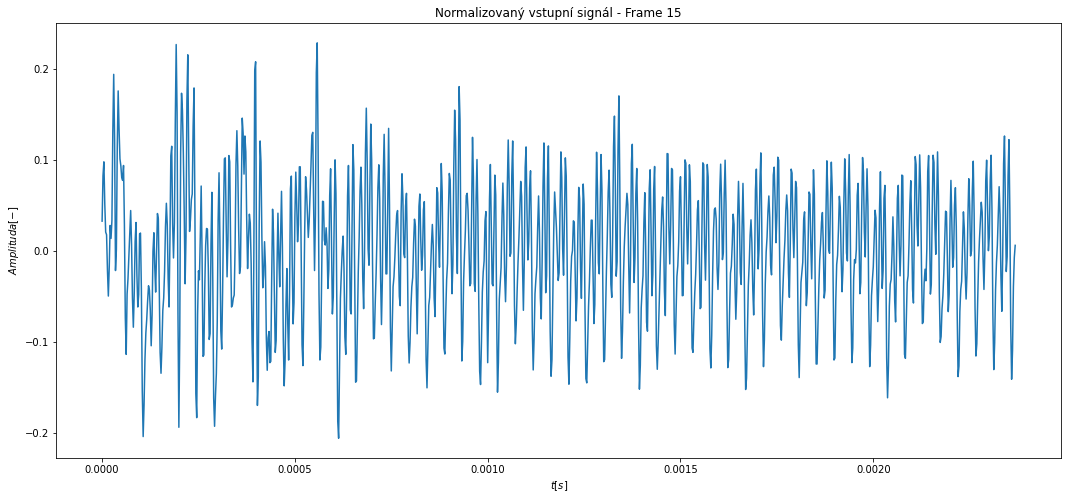

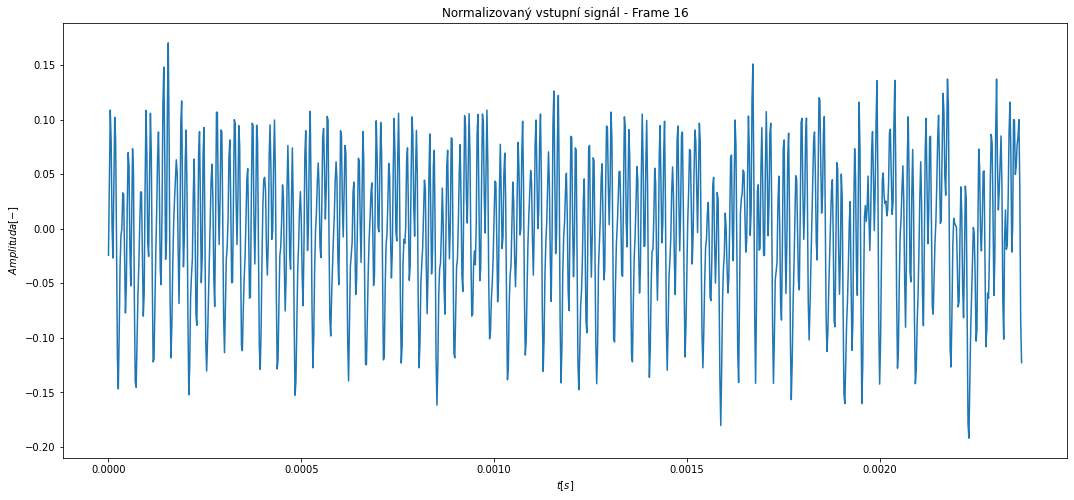

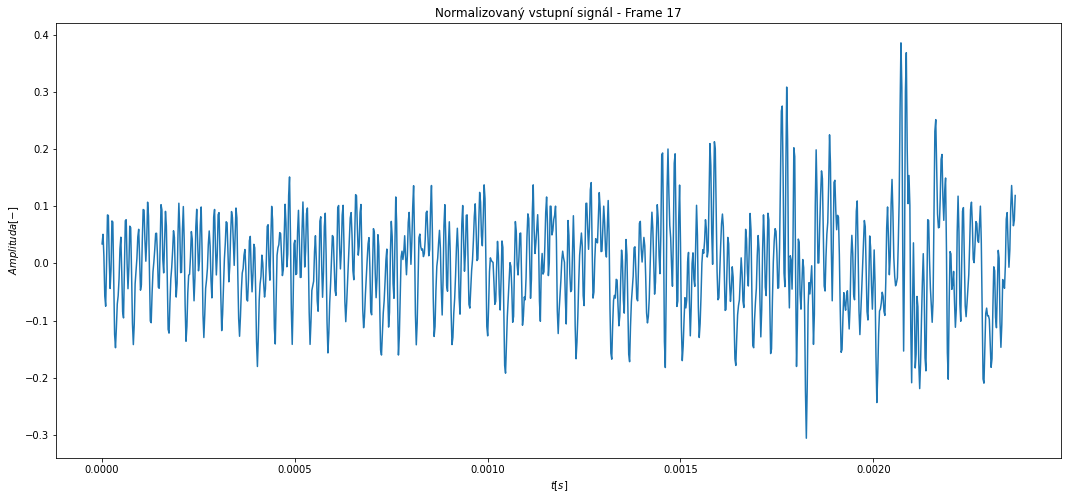

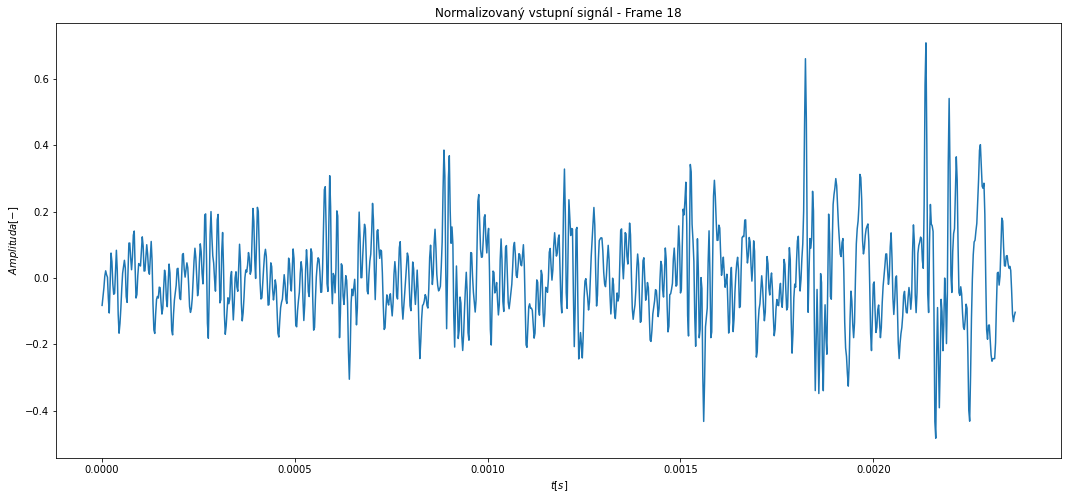

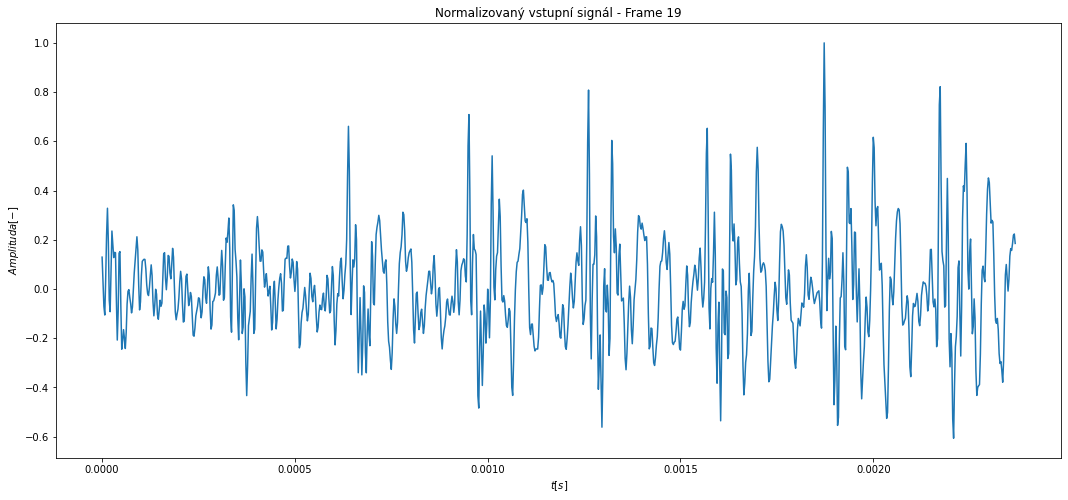

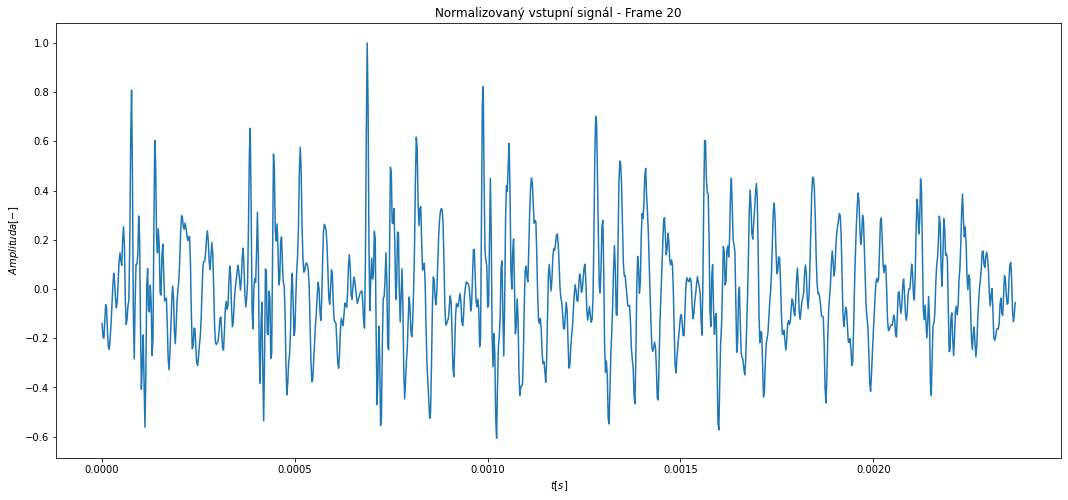

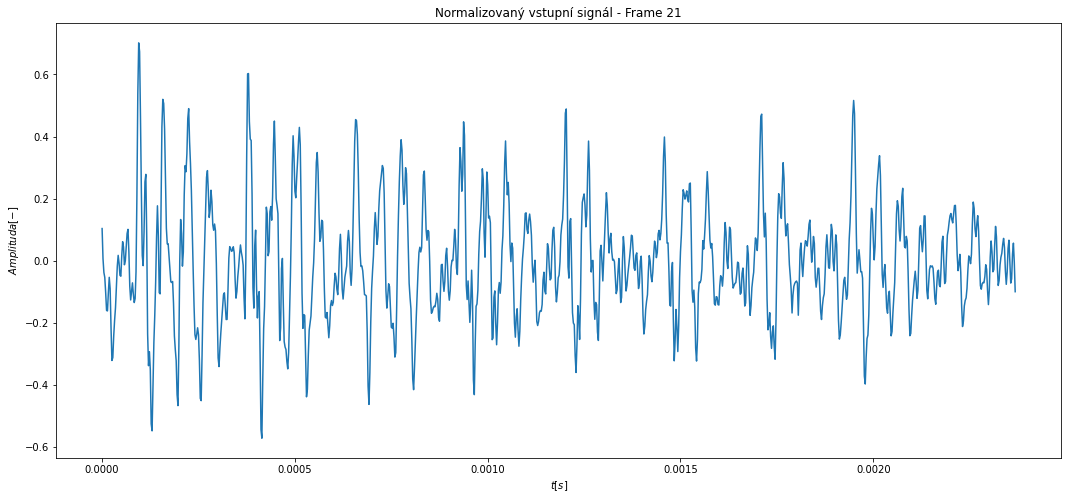

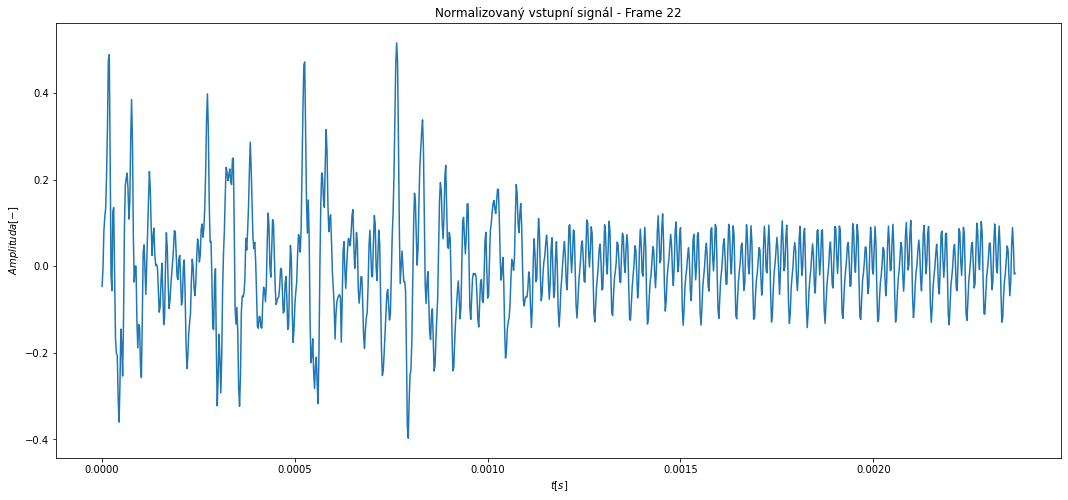

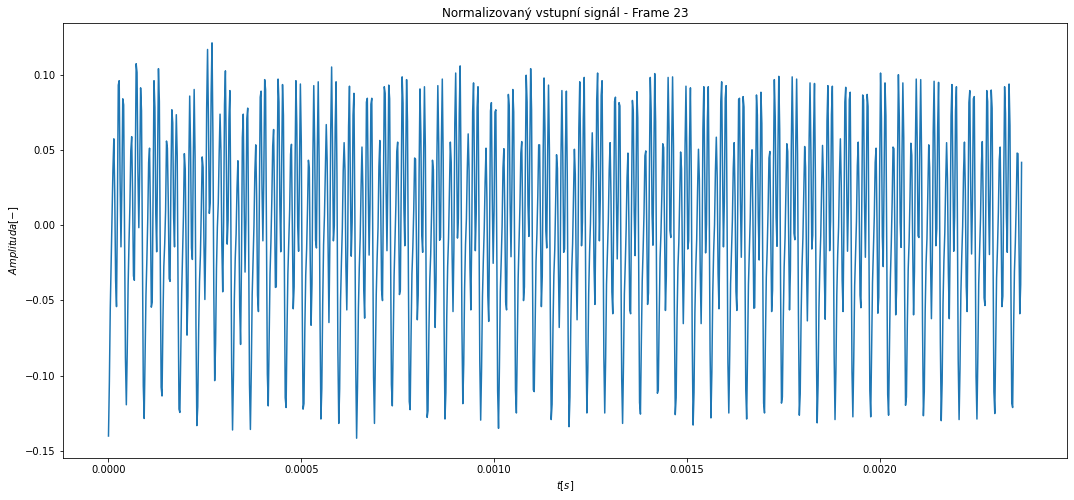

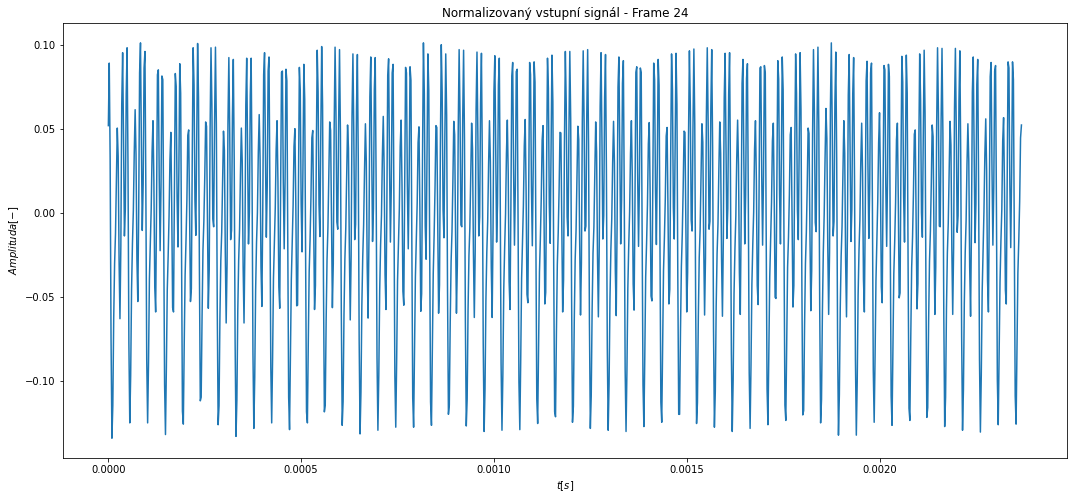

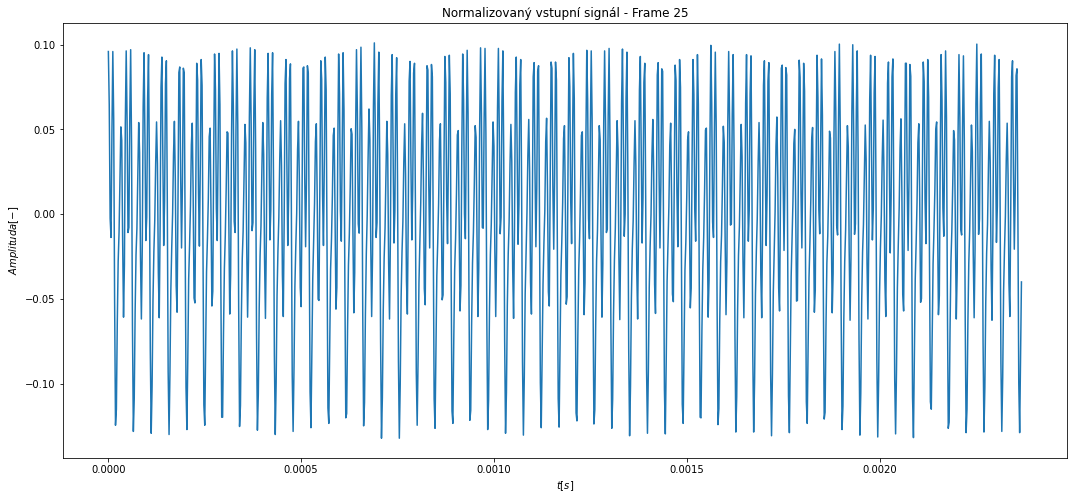

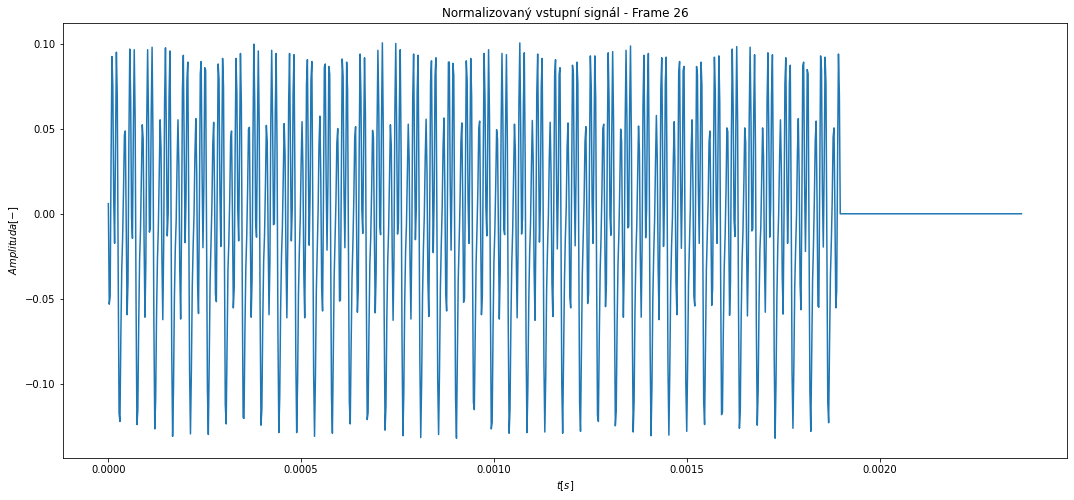

In [91]:
# Show all frames
for i in range(number_of_frames):
  plt.figure(figsize=(18,8))
  plt.title(f"Normalizovaný vstupní signál - Frame {i}")
  plt.plot(np.arange(frames[i].size) / sample_freq / number_of_frames, frames[i])
  plt.gca().set_xlabel('$t[s]$')
  plt.gca().set_ylabel('$Amplituda[-]$')
  plt.show()

# Make cols from data
frames_transformed = np.array(frames).reshape(FRAME_SIZE, number_of_frames)

Fourier transform

Are DFTs same: True


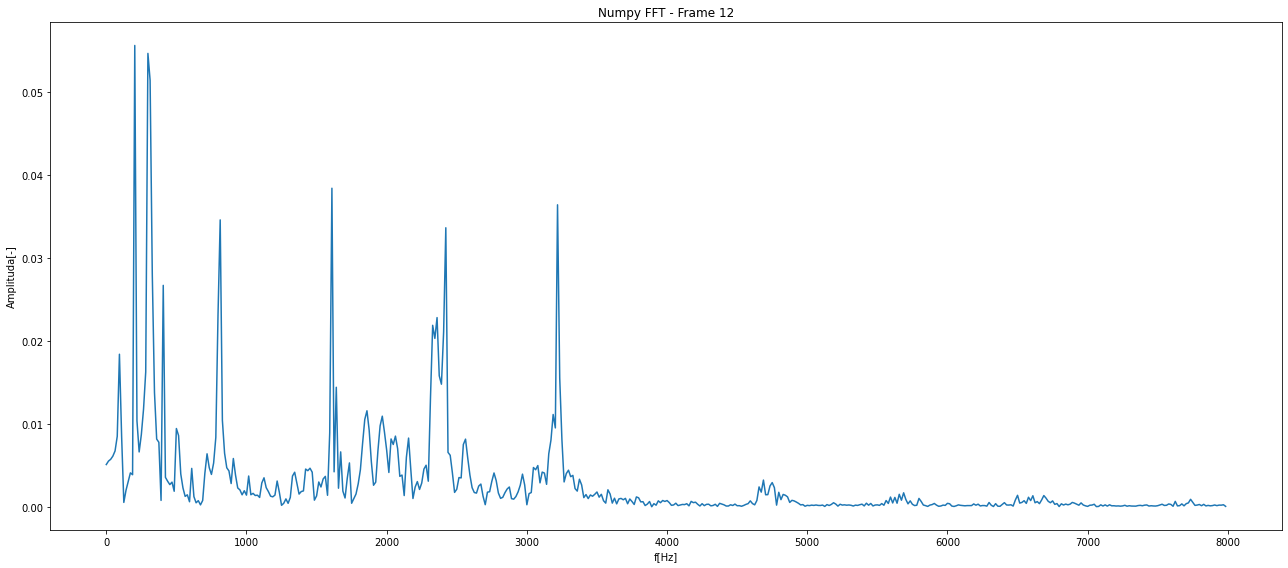

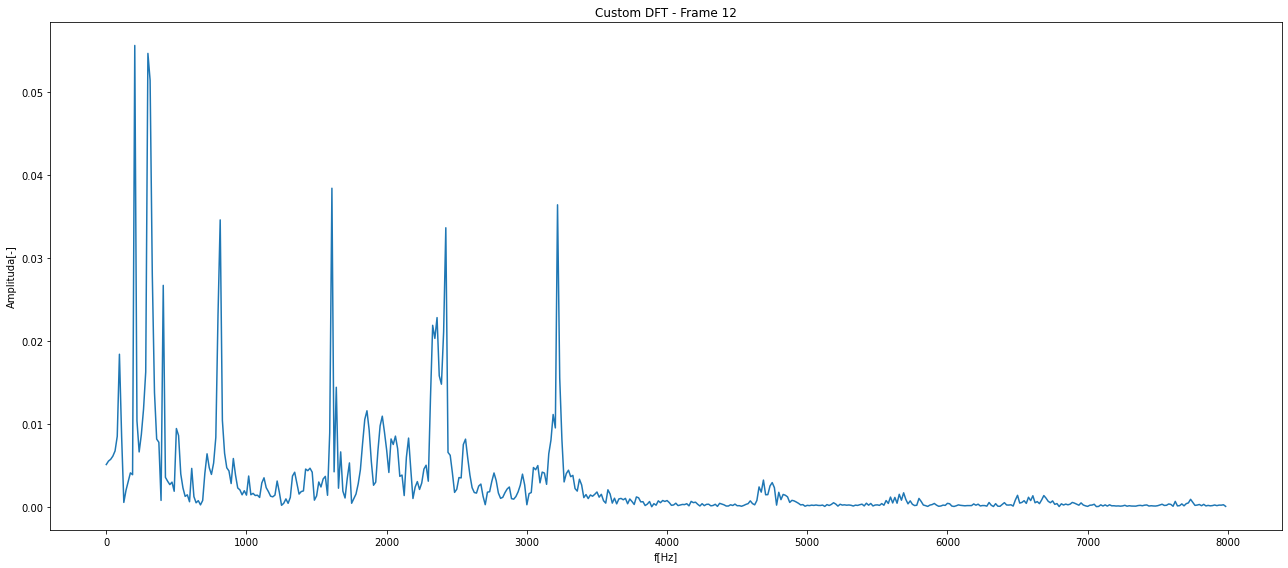

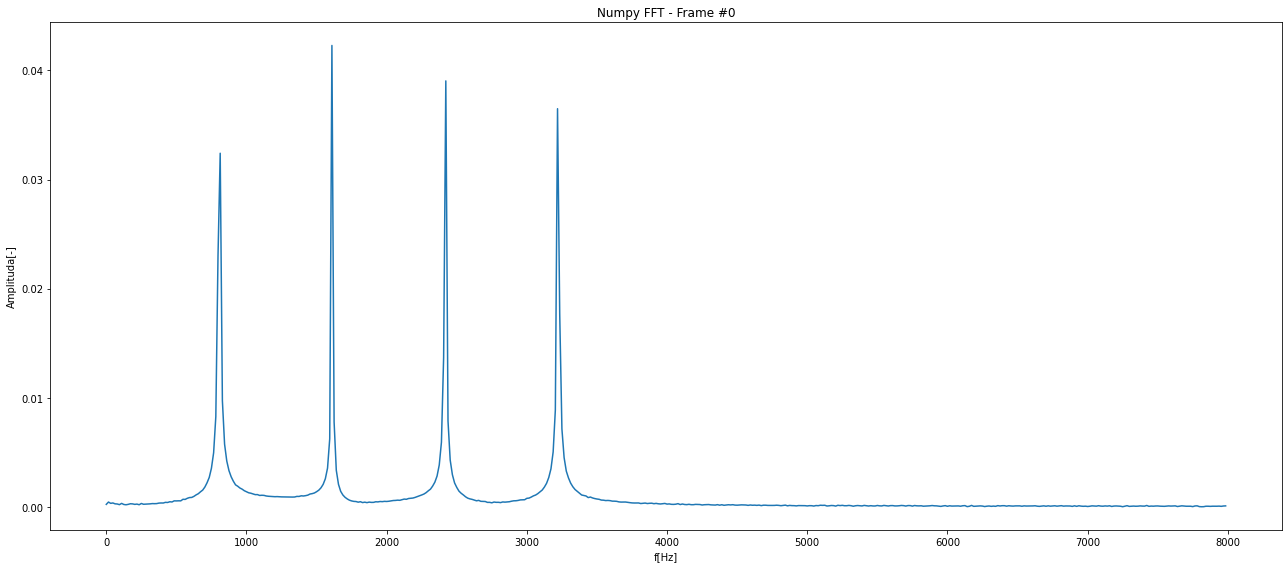

In [92]:
# Fourier transform
def dft(x):
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

buildin_fft = np.fft.fft(frames[11])
custom_dft = dft(frames[11])

data_length = len(buildin_fft)
sample_indexes = np.arange(data_length)
T = data_length/sample_freq
freq = sample_indexes/T

half_length = data_length//2
freq_one_side = freq[:half_length]

vals_buildin = buildin_fft[:half_length]/half_length
vals_custom = custom_dft[:half_length]/half_length

print(f"Are DFTs same: {np.allclose(vals_buildin, vals_custom)}")

# Plot result of custom dft and numpy fft
plt.figure(figsize=(18,8))
plt.title(f"Numpy FFT - Frame 12")
plt.plot(freq_one_side, abs(vals_buildin))
plt.xlabel('f[Hz]')
plt.ylabel('Amplituda[-]')
plt.tight_layout()
plt.show()

plt.figure(figsize=(18,8))
plt.title(f"Custom DFT - Frame 12")
plt.plot(freq_one_side, abs(vals_buildin))
plt.xlabel('f[Hz]')
plt.ylabel('Amplituda[-]')
plt.tight_layout()
plt.show()

buildin_fft = np.fft.fft(frames[0])
vals_buildin = buildin_fft[:half_length]/half_length

plt.figure(figsize=(18,8))
plt.title(f"Numpy FFT - Frame #0")
plt.plot(freq_one_side, abs(vals_buildin))
plt.xlabel('f[Hz]')
plt.ylabel('Amplituda[-]')
plt.tight_layout()
plt.show()

Spektrogram

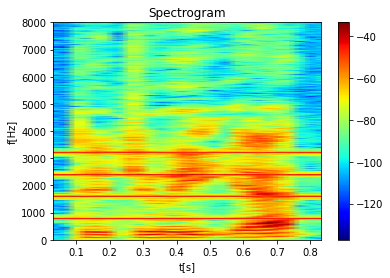

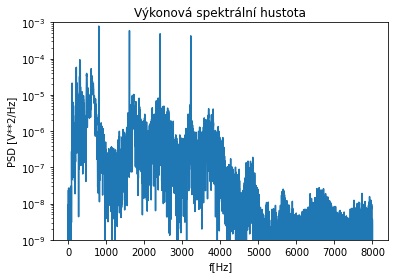

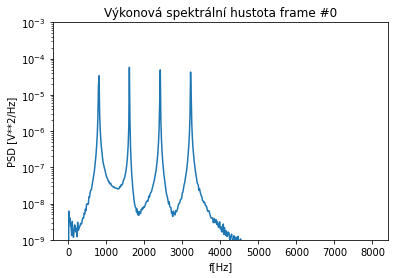

In [93]:
f, t, Sxx = signal.spectrogram(samples_normal, sample_freq, nperseg=FRAME_SIZE, noverlap=FRAME_OVERLAP)
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='jet')
plt.title("Spectrogram")
plt.colorbar()
plt.ylabel('f[Hz]')
plt.xlabel('t[s]')
plt.show()

f, Pxx = signal.periodogram(samples_normal, sample_freq, scaling="density")
plt.semilogy(f, Pxx)
plt.title("Výkonová spektrální hustota")
plt.ylim([1e-9, 1e-3])
plt.xlabel('f[Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

f2, Pxx2 = signal.periodogram(frames[0], sample_freq, scaling="density")
plt.semilogy(f2, Pxx2)
plt.title("Výkonová spektrální hustota frame #0")
plt.ylim([1e-9, 1e-3])
plt.xlabel('f[Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

Get noise frequencies

In [94]:
def get_noise_frequencies(x, y, number_of_tops, band_width=100):
  signal_copy = y.copy()

  output = []

  half_width = band_width // 2

  for i in range(number_of_tops):
    idx = (-signal_copy).argsort()[0]
    output.append(x[idx])

    low_index = idx - half_width
    high_index = idx + half_width
    signal_copy[low_index : high_index] = 0
  return output

In [95]:
f, Pxx = signal.periodogram(frames[0], sample_freq, scaling="density")

top_4_freqs = get_noise_frequencies(f, Pxx, 4)
top_4_freqs.sort()

print(f"Found noise frequencies: {top_4_freqs}")

top_4_freqs = [round(num, 3) for num in top_4_freqs]
print(f"Found noise frequencies rounded: {top_4_freqs}")

Found noise frequencies: [812.5, 1609.375, 2421.875, 3218.75]
Found noise frequencies rounded: [812.5, 1609.375, 2421.875, 3218.75]


Generate noise

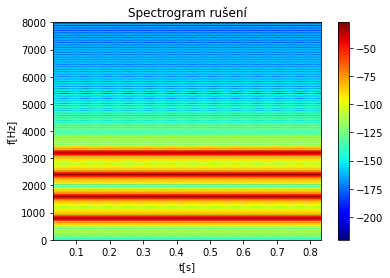

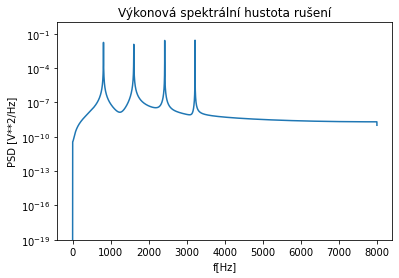

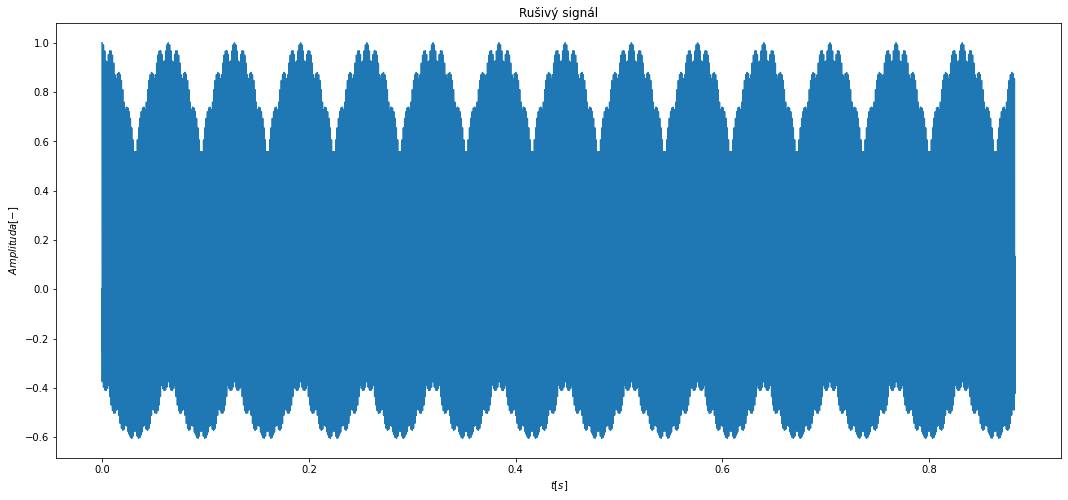

In [96]:
time = np.linspace(0, orig_length_in_secs, samples_orig.size, endpoint=False)
noise_signal = np.cos(2 * np.pi * top_4_freqs[0] * time) + \
               np.cos(2 * np.pi * top_4_freqs[1] * time) + \
               np.cos(2 * np.pi * top_4_freqs[2] * time) + \
               np.cos(2 * np.pi * top_4_freqs[3] * time)

noise_signal = normalization(noise_signal)
wavfile.write("../audio/4cos.wav", sample_freq, (noise_signal * np.iinfo(np.int16).max).astype(np.int16))

# Plot noise
f, t, Sxx = signal.spectrogram(noise_signal, sample_freq, nperseg=FRAME_SIZE, noverlap=FRAME_OVERLAP)
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='jet')
plt.title("Spectrogram rušení")
plt.colorbar()
plt.ylabel('f[Hz]')
plt.xlabel('t[s]')
plt.show()

f, Pxx = signal.periodogram(noise_signal, sample_freq, scaling="density")
plt.semilogy(f, Pxx)
plt.title("Výkonová spektrální hustota rušení")
plt.xlabel('f[Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.ylim([1e-19, 1e-0])
plt.show()

plt.figure(figsize=(18,8))
plt.title("Rušivý signál")
plt.plot(np.arange(noise_signal.size) / sample_freq, noise_signal)
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_ylabel('$Amplituda[-]$')
plt.show()

Filter

In [97]:
nyq = 0.5 * sample_freq

def ellip_filter(cut_freq, output="sos"):
    block_left = cut_freq - BAND_STOP_WIDTH // 2
    block_right = cut_freq + BAND_STOP_WIDTH // 2
    open_left = block_left - BAND_DESCEND_WIDTH
    open_right = block_right + BAND_DESCEND_WIDTH

    N, Wn = signal.ellipord([open_left / nyq, open_right / nyq], [block_left / nyq, block_right / nyq], PASS_LOSS, BLOCK_ATT)
    return signal.ellip(N, PASS_LOSS, BLOCK_ATT, Wn, 'bandstop', output=output)

def butter_filter(cut_freq, output="ba"):
    block_left = cut_freq - BAND_STOP_WIDTH // 2
    block_right = cut_freq + BAND_STOP_WIDTH // 2
    open_left = block_left - BAND_DESCEND_WIDTH
    open_right = block_right + BAND_DESCEND_WIDTH

    N, Wn = signal.buttord([open_left / nyq, open_right / nyq], [block_left / nyq, block_right / nyq], PASS_LOSS, BLOCK_ATT)
    return signal.butter(N, Wn, 'bandstop', output=output)

In [98]:
# Create array of filters
sos_el = [ellip_filter(freq, "sos") for freq in top_4_freqs]
sos_bt = [butter_filter(freq, "sos") for freq in top_4_freqs]

Coefs

In [99]:
# Coefs
print("Elliptic coefs")
for idx, sos in enumerate(sos_el):
  b, a = signal.sos2tf(sos)
  print(f"{idx + 1}:\tb: {b.tolist()},\n\ta: {a.tolist()}")

print("\nButterworth coefs")
for idx, sos in enumerate(sos_bt):
  b, a = signal.sos2tf(sos)
  print(f"{idx + 1}:\tb: {b.tolist()},\n\ta: {a.tolist()}")

Elliptic coefs
1:	b: [0.9195102574936844, -5.238408160748027, 12.706157788627303, -16.773575074971045, 12.706157788627305, -5.238408160748028, 0.9195102574936846],
	a: [1.0, -5.5417441172090856, 13.070099090812064, -16.769205449366034, 12.339915584327985, -4.939441829891976, 0.8413214171019202]
2:	b: [0.9181085584896604, -4.444477811473829, 9.925980111930595, -12.746312956434963, 9.925980111930594, -4.444477811473828, 0.9181085584896602],
	a: [1.0, -4.706681537441751, 10.215282760246987, -12.742465830618883, 9.634293468132475, -4.186121211321982, 0.838601112461047]
3:	b: [0.917532582398649, -3.1973822297267294, 6.466418396885576, -7.832571465855114, 6.466418396885576, -3.1973822297267294, 0.9175325823986491],
	a: [1.0, -3.387446939503964, 6.655825654455542, -7.829761895313213, 6.2745925494009684, -3.0101270904913924, 0.8374837547119365]
4:	b: [0.9171652353037931, -1.6618787210358548, 3.7549544860910125, -3.5256629072604344, 3.754954486091012, -1.6618787210358543, 0.9171652353037928],
	

Dirac inpulse response

In [100]:
dirac_impulse = np.zeros((256,))
dirac_impulse[0] = 1

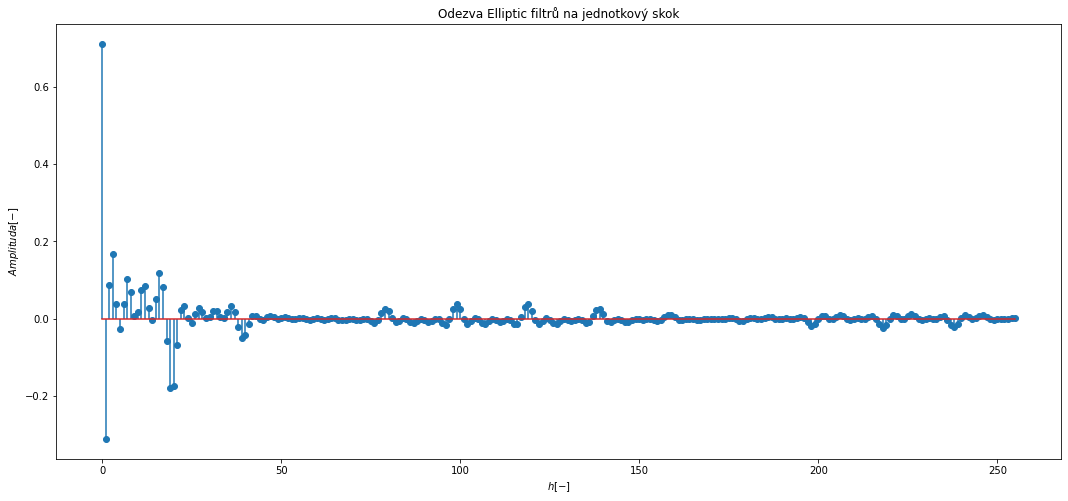

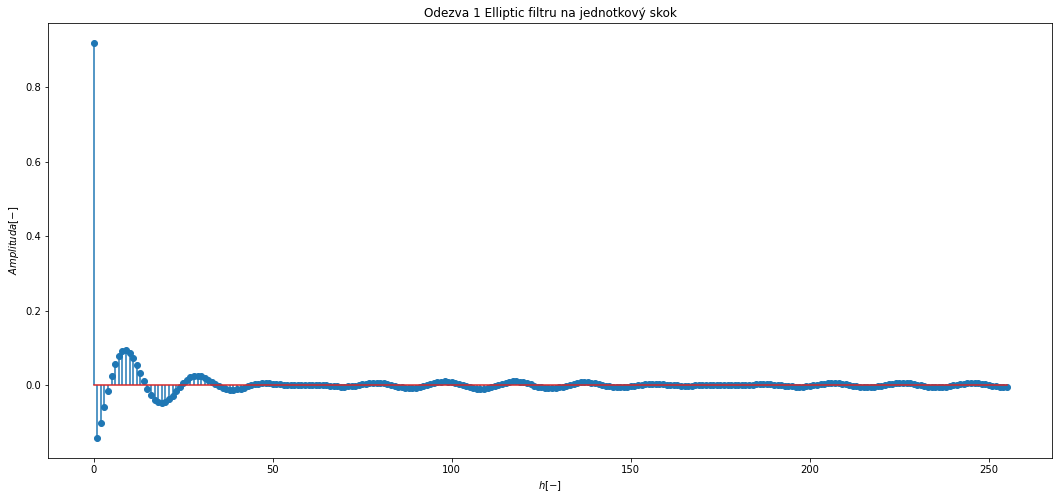

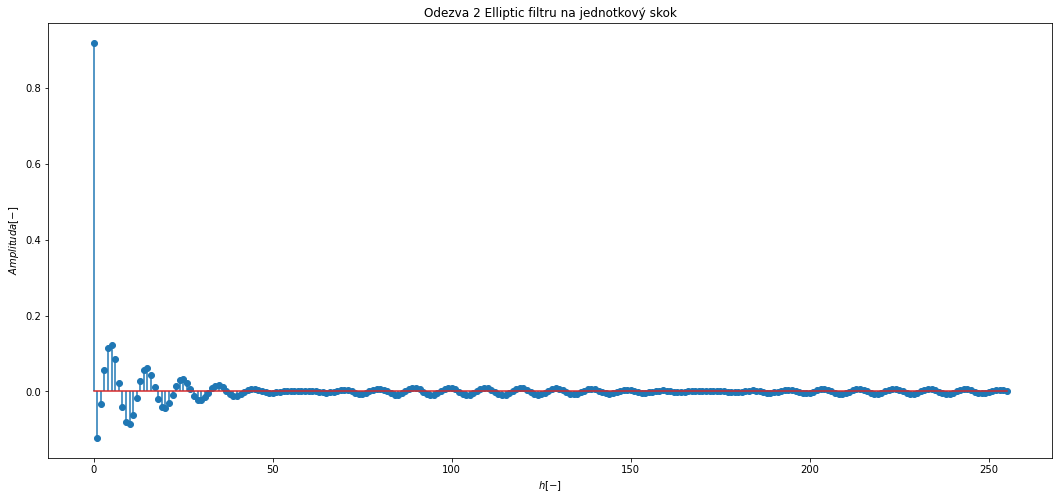

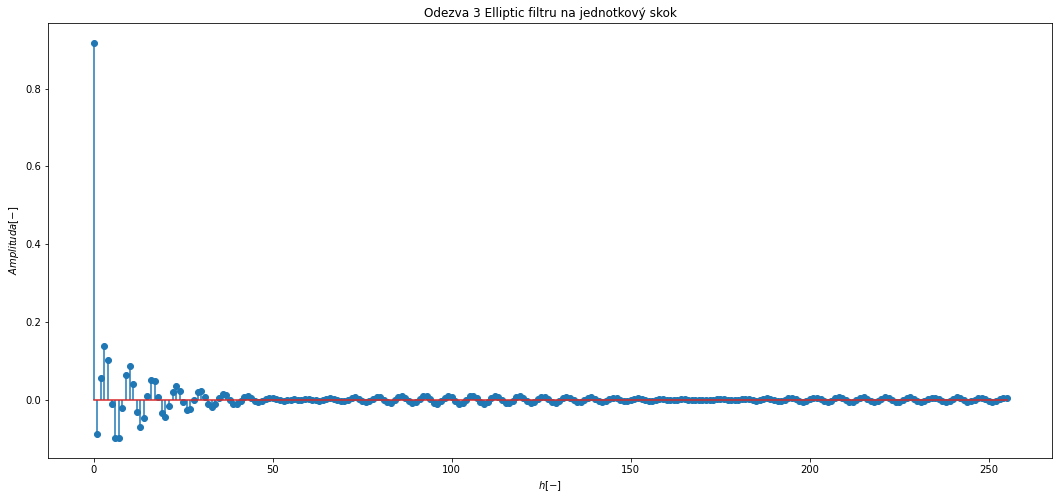

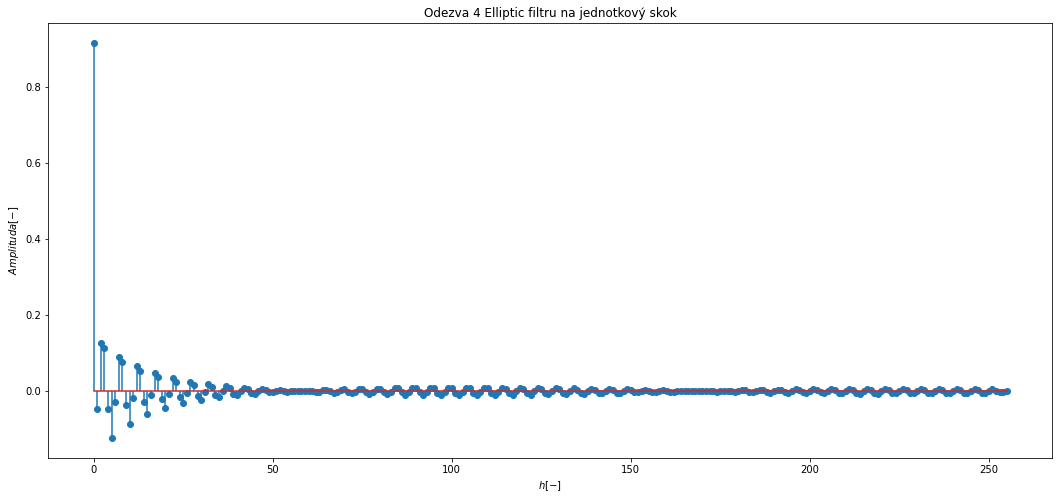

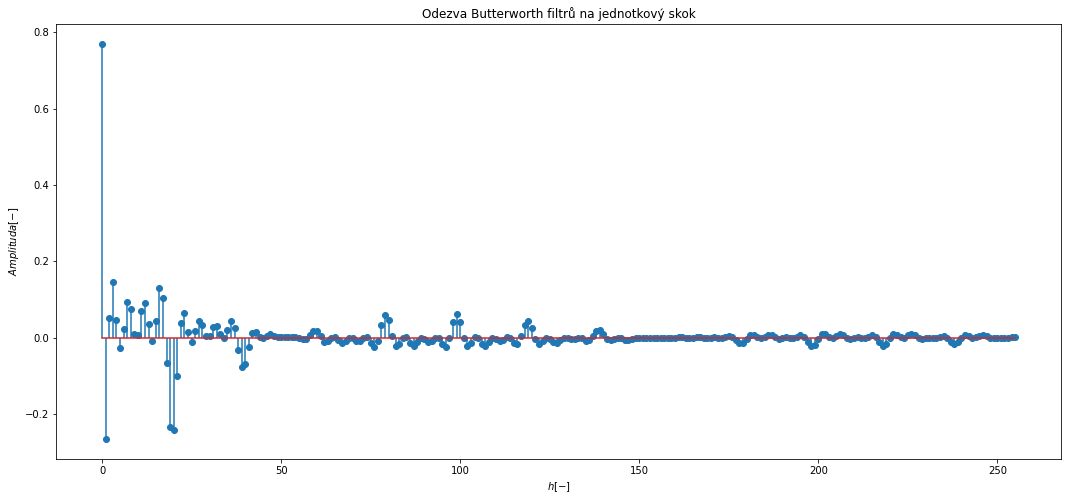

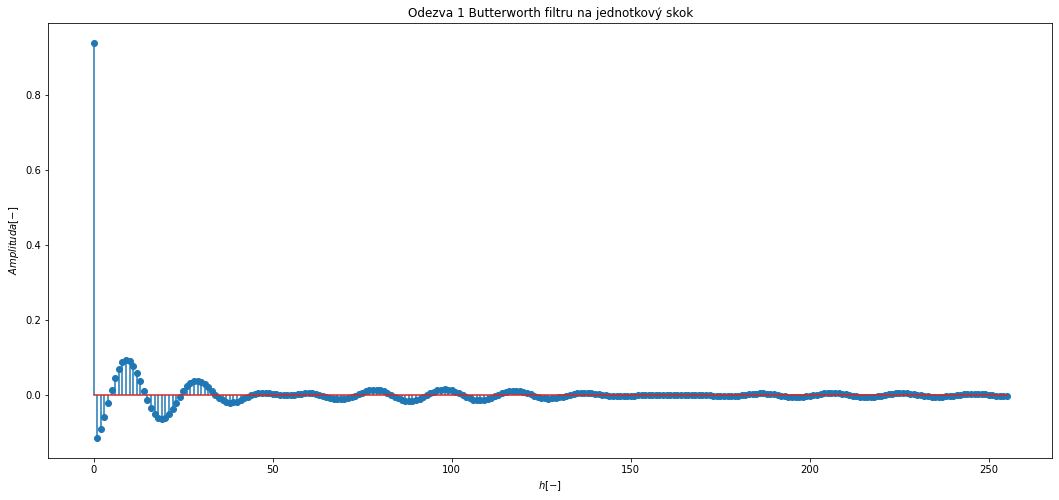

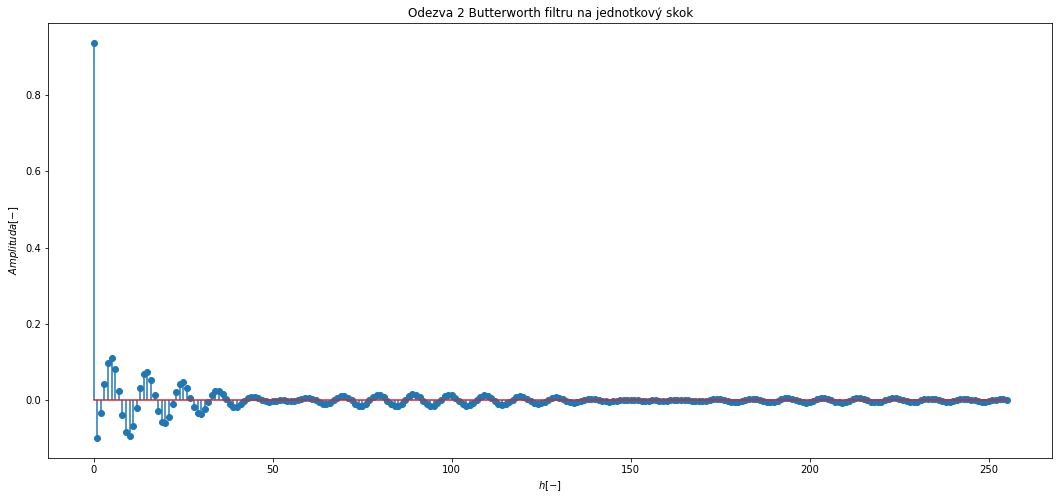

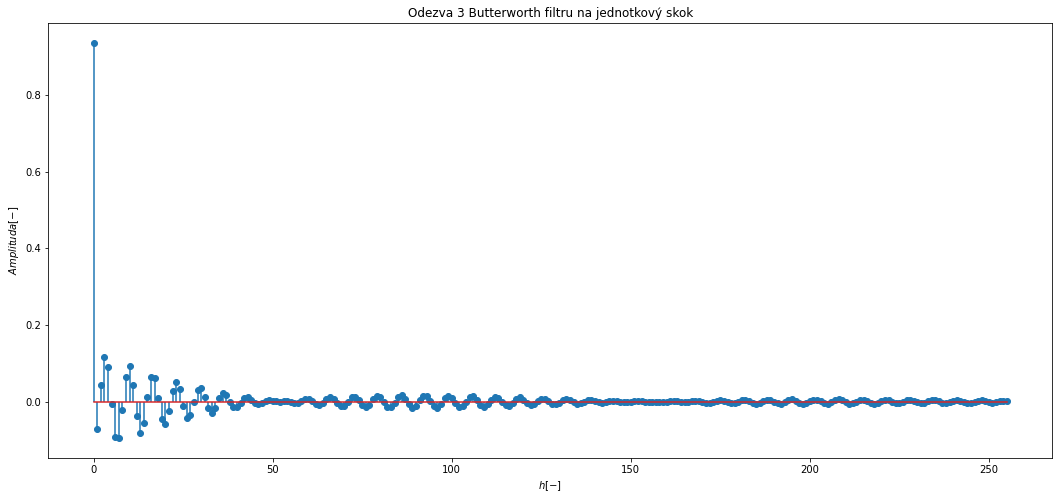

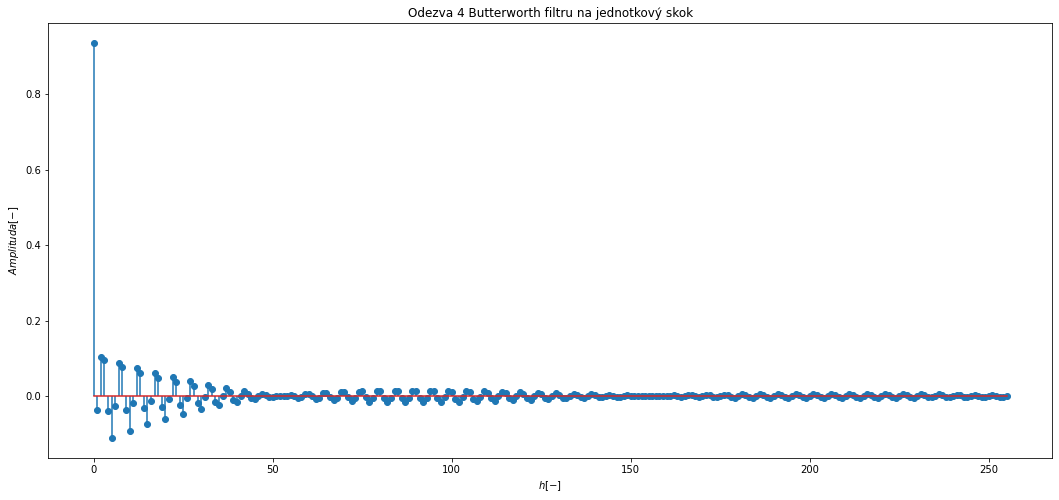

In [101]:
data = dirac_impulse
for sos in sos_el:
    data = signal.sosfilt(sos, data)

plt.figure(figsize=(18,8))
plt.title("Odezva Elliptic filtrů na jednotkový skok")
plt.stem(np.arange(data.size), data)
plt.gca().set_xlabel('$h[-]$')
plt.gca().set_ylabel('$Amplituda[-]$')
plt.show()

for idx, sos in enumerate(sos_el):
    data = signal.sosfilt(sos, dirac_impulse)

    plt.figure(figsize=(18,8))
    plt.title(f"Odezva {idx + 1} Elliptic filtru na jednotkový skok")
    plt.stem(np.arange(data.size), data)
    plt.gca().set_xlabel('$h[-]$')
    plt.gca().set_ylabel('$Amplituda[-]$')
    plt.show()


data = dirac_impulse
for sos in sos_bt:
    data = signal.sosfilt(sos, data)

plt.figure(figsize=(18,8))
plt.title("Odezva Butterworth filtrů na jednotkový skok")
plt.stem(np.arange(data.size), data)
plt.gca().set_xlabel('$h[-]$')
plt.gca().set_ylabel('$Amplituda[-]$')
plt.show()

for idx, sos in enumerate(sos_bt):
    data = signal.sosfilt(sos, dirac_impulse)

    plt.figure(figsize=(18,8))
    plt.title(f"Odezva {idx + 1} Butterworth filtru na jednotkový skok")
    plt.stem(np.arange(data.size), data)
    plt.gca().set_xlabel('$h[-]$')
    plt.gca().set_ylabel('$Amplituda[-]$')
    plt.show()

Frequency characteristics

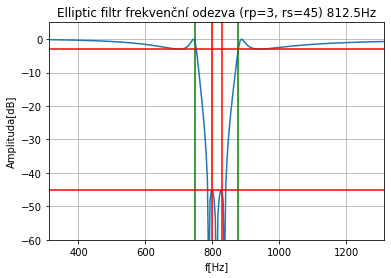

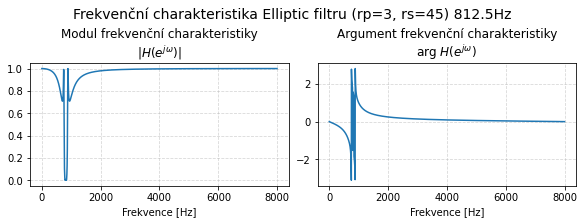

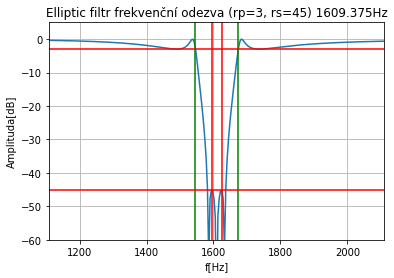

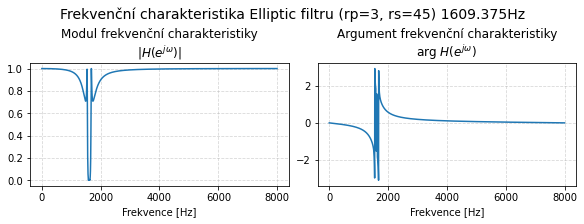

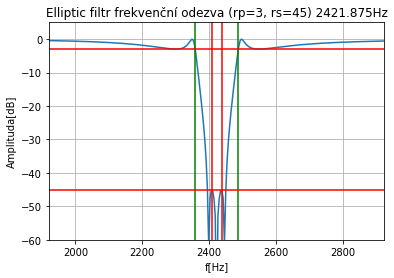

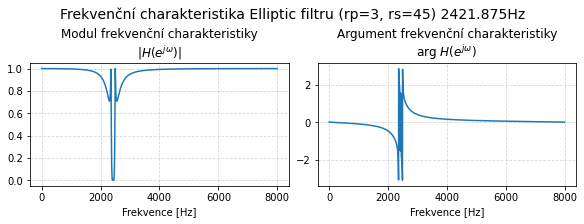

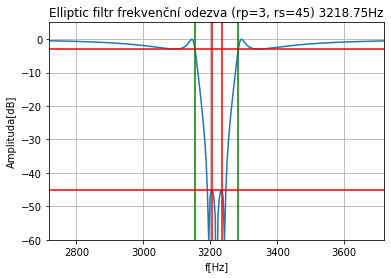

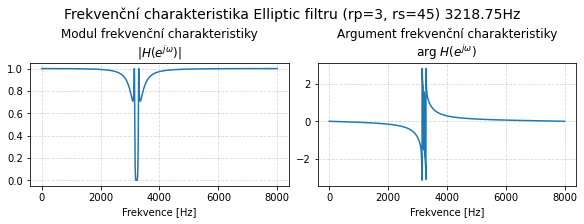

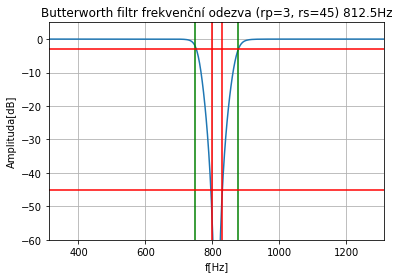

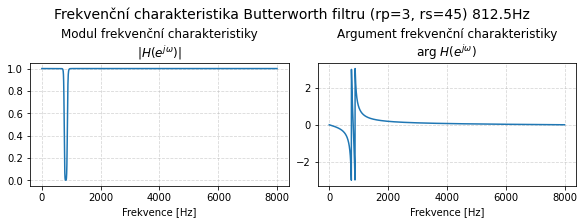

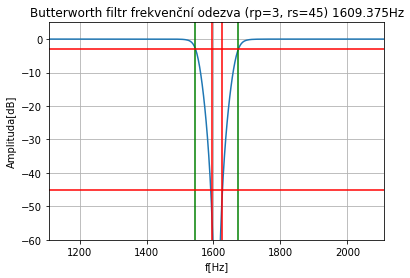

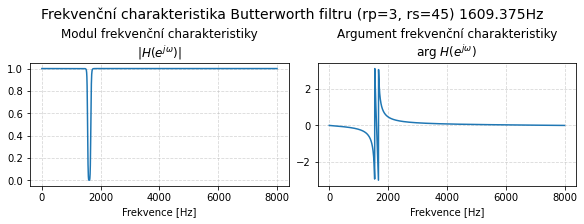

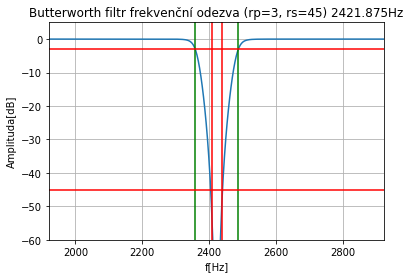

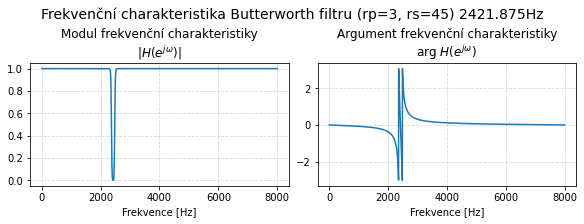

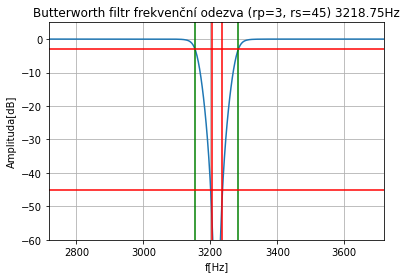

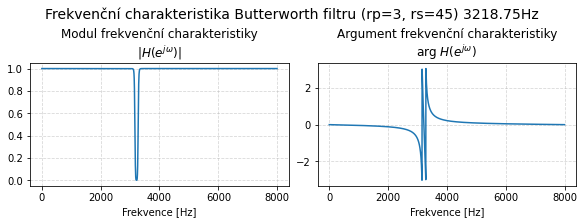

In [102]:
for i, sos in enumerate(sos_el):
    w, h = signal.sosfreqz(sos, 2048)

    block_left = (top_4_freqs[i] - BAND_STOP_WIDTH / 2)
    block_right = (top_4_freqs[i] + BAND_STOP_WIDTH / 2)
    open_left = (block_left - BAND_DESCEND_WIDTH)
    open_right = (block_right + BAND_DESCEND_WIDTH)

    plt.plot(w / 2 / np.pi * sample_freq, 20 * np.log10(abs(h)))
    plt.title(f'Elliptic filtr frekvenční odezva (rp={PASS_LOSS}, rs={BLOCK_ATT}) {top_4_freqs[i]}Hz')
    plt.xlabel('f[Hz]')
    plt.ylabel('Amplituda[dB]')
    plt.axvline(open_left, color='green')
    plt.axvline(open_right, color='green')
    plt.axvline(block_left, color='red')
    plt.axvline(block_right, color='red')
    plt.axhline(-BLOCK_ATT, color='red') # rs
    plt.axhline(-PASS_LOSS, color='red') # rp
    plt.xlim([top_4_freqs[i] - 500, top_4_freqs[i] + 500])
    plt.ylim([-60, 5])
    plt.grid(which='both', axis='both')
    plt.show();

    fig, ax = plt.subplots(1, 2, figsize=(8,3), constrained_layout=True)
    fig.suptitle(f'Frekvenční charakteristika Elliptic filtru (rp={PASS_LOSS}, rs={BLOCK_ATT}) {top_4_freqs[i]}Hz', fontsize=14)

    ax[0].plot(w / 2 / np.pi * sample_freq, np.abs(h))
    ax[0].set_xlabel('Frekvence [Hz]')
    ax[0].set_title('Modul frekvenční charakteristiky\n$|H(e^{j\omega})|$')

    ax[1].plot(w / 2 / np.pi * sample_freq, np.angle(h))
    ax[1].set_xlabel('Frekvence [Hz]')
    ax[1].set_title('Argument frekvenční charakteristiky\n$\mathrm{arg}\ H(e^{j\omega})$')

    for ax1 in ax:
        ax1.grid(alpha=0.5, linestyle='--')
    plt.show()


for i, sos in enumerate(sos_bt):
    w, h = signal.sosfreqz(sos, 2048)

    block_left = (top_4_freqs[i] - BAND_STOP_WIDTH / 2)
    block_right = (top_4_freqs[i] + BAND_STOP_WIDTH / 2)
    open_left = (block_left - BAND_DESCEND_WIDTH)
    open_right = (block_right + BAND_DESCEND_WIDTH)

    plt.plot(w / 2 / np.pi * sample_freq, 20 * np.log10(abs(h)))
    plt.title(f'Butterworth filtr frekvenční odezva (rp={PASS_LOSS}, rs={BLOCK_ATT}) {top_4_freqs[i]}Hz')
    plt.xlabel('f[Hz]')
    plt.ylabel('Amplituda[dB]')
    plt.axvline(open_left, color='green')
    plt.axvline(open_right, color='green')
    plt.axvline(block_left, color='red')
    plt.axvline(block_right, color='red')
    plt.axhline(-BLOCK_ATT, color='red') # rs
    plt.axhline(-PASS_LOSS, color='red') # rp
    plt.xlim([top_4_freqs[i] - 500, top_4_freqs[i] + 500])
    plt.ylim([-60, 5])
    plt.grid(which='both', axis='both')
    plt.show();

    fig, ax = plt.subplots(1, 2, figsize=(8,3), constrained_layout=True)
    fig.suptitle(f'Frekvenční charakteristika Butterworth filtru (rp={PASS_LOSS}, rs={BLOCK_ATT}) {top_4_freqs[i]}Hz', fontsize=14)

    ax[0].plot(w / 2 / np.pi * sample_freq, np.abs(h))
    ax[0].set_xlabel('Frekvence [Hz]')
    ax[0].set_title('Modul frekvenční charakteristiky\n$|H(e^{j\omega})|$')

    ax[1].plot(w / 2 / np.pi * sample_freq, np.angle(h))
    ax[1].set_xlabel('Frekvence [Hz]')
    ax[1].set_title('Argument frekvenční charakteristiky\n$\mathrm{arg}\ H(e^{j\omega})$')

    for ax1 in ax:
        ax1.grid(alpha=0.5, linestyle='--')
    plt.show()

Zeroes and poles

BA
[0.94954573+0.3136286j 0.94954573-0.3136286j 0.94954573+0.3136286j
 0.94954573-0.3136286j 0.94954573+0.3136286j 0.94954573-0.3136286j
 0.94954573+0.3136286j 0.94954573-0.3136286j], [0.92483774+0.31450528j 0.92483774-0.31450528j 0.93182134+0.29738584j
 0.93182134-0.29738584j 0.93250068+0.33240885j 0.93250068-0.33240885j
 0.94789218+0.2899975j  0.94789218-0.2899975j ]
[0.80686611+0.59073436j 0.80686611-0.59073436j 0.80686611+0.59073436j
 0.80686611-0.59073436j 0.80686611+0.59073436j 0.80686611-0.59073436j
 0.80686611+0.59073436j 0.80686611-0.59073436j], [0.78271914+0.58432376j 0.78271914-0.58432376j 0.79429156+0.56951562j
 0.79429156-0.56951562j 0.78494863+0.60352023j 0.78494863-0.60352023j
 0.81258348+0.56681762j 0.81258348-0.56681762j]
[0.58082725+0.81402685j 0.58082725-0.81402685j 0.58082725+0.81402685j
 0.58082725-0.81402685j 0.58082725+0.81402685j 0.58082725-0.81402685j
 0.58082725+0.81402685j 0.58082725-0.81402685j], [0.55972152+0.80046138j 0.55972152-0.80046138j 0.57530543+0.78

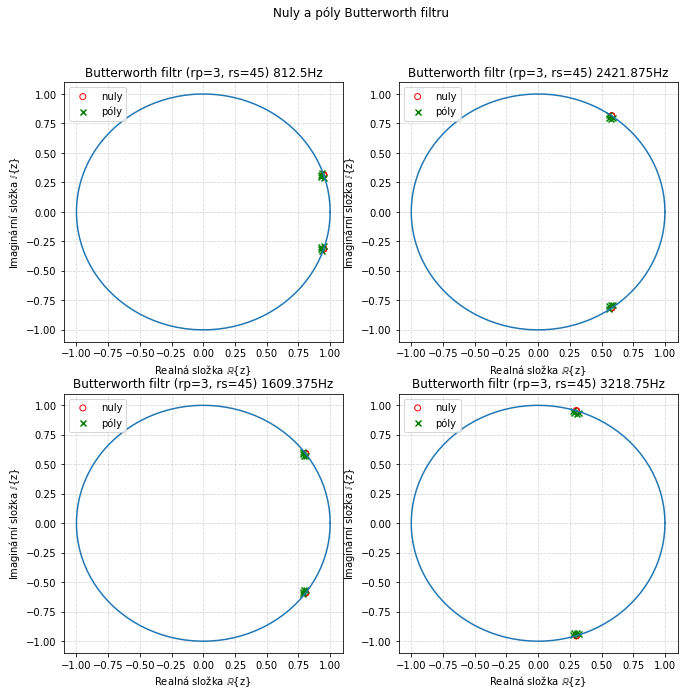

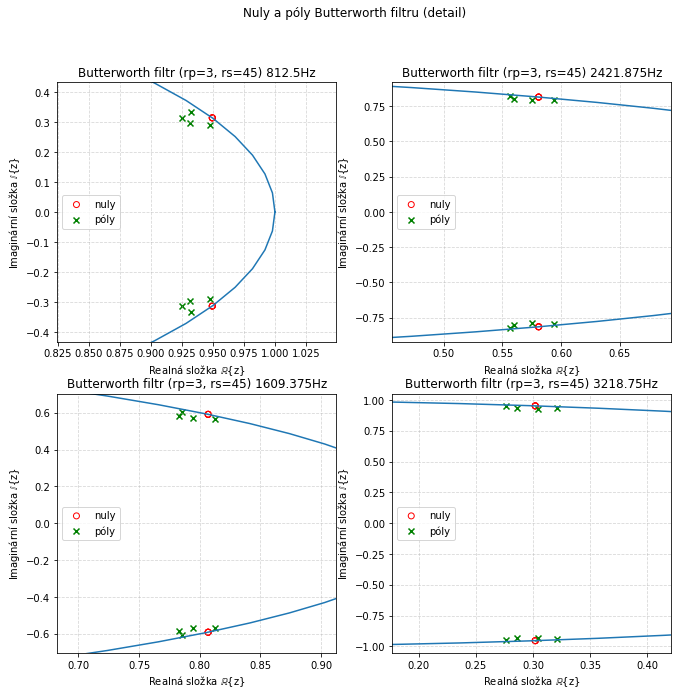


EL
[0.94954618+0.31362726j 0.94954618-0.31362726j 0.94657455+0.32248508j
 0.94657455-0.32248508j 0.95235656+0.30498685j 0.95235656-0.30498685j], [0.8806448 +0.28167336j 0.8806448 -0.28167336j 0.93655802+0.33803835j
 0.93655802-0.33803835j 0.95366924+0.2884208j  0.95366924-0.2884208j ]
[0.80686517+0.59073565j 0.80686517-0.59073565j 0.80124871+0.59833143j
 0.80124871-0.59833143j 0.81233944+0.5831849j  0.81233944-0.5831849j ], [0.7473044 +0.54212651j 0.7473044 -0.54212651j 0.78709868+0.60997798j
 0.78709868-0.60997798j 0.81893769+0.56703621j 0.81893769-0.56703621j]
[0.58082822+0.81402615j 0.58082822-0.81402615j 0.57307762+0.81950109j
 0.57307762-0.81950109j 0.58847491+0.80851548j 0.58847491-0.80851548j], [0.53765344+0.74984167j 0.53765344-0.74984167j 0.55606428+0.8261162j
 0.55606428-0.8261162j  0.60000575+0.79497319j 0.60000575-0.79497319j]
[0.30201369+0.95330359j 0.30201369-0.95330359j 0.29292763+0.95613462j
 0.29292763-0.95613462j 0.31104522+0.95039511j 0.31104522-0.95039511j], [0.279

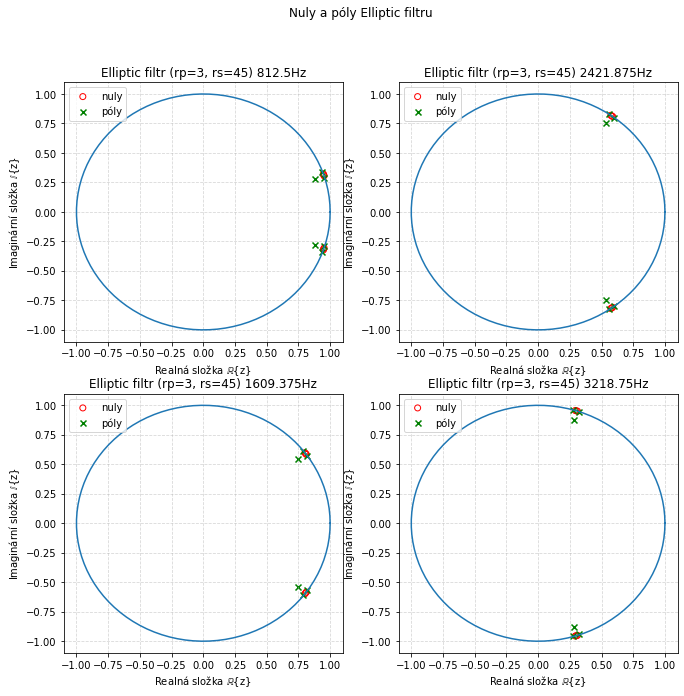

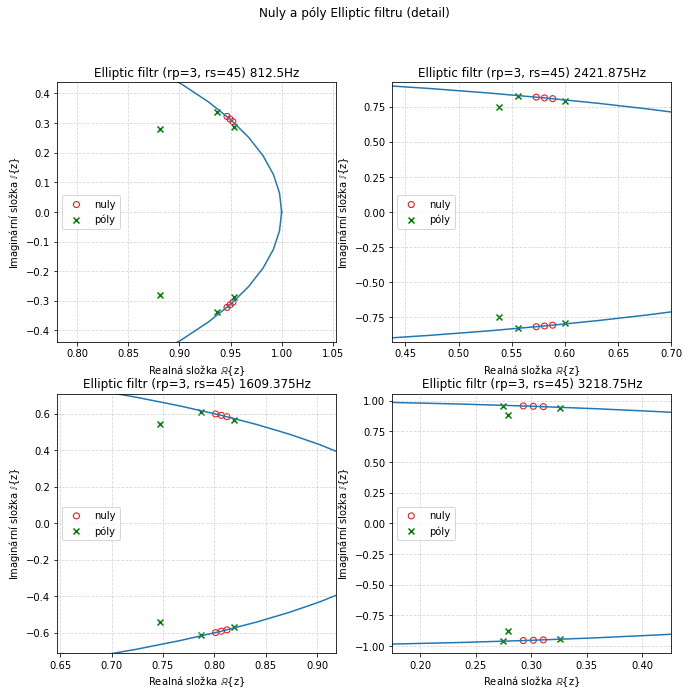

In [103]:
print("BA")
fig, axs = plt.subplots(2, 2, figsize=(11,10.5))
fig.suptitle("Nuly a póly Butterworth filtru")
i = j = k = 0

for l, sos in enumerate(sos_bt):
    z, p, _ = signal.sos2zpk(sos)

    print(f"{z}, {p}")

    # jednotkova kruznice
    ang = np.linspace(0, 2*np.pi,100)
    axs[i, j].plot(np.cos(ang), np.sin(ang))

    # nuly, poly
    axs[i, j].scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
    axs[i, j].scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')

    axs[i, j].set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
    axs[i, j].set_ylabel('Imaginární složka $\mathbb{I}\{$z$\}$')

    axs[i, j].grid(alpha=0.5, linestyle='--')
    axs[i, j].legend(loc='upper left')

    axs[i, j].set_title(f"Butterworth filtr (rp={PASS_LOSS}, rs={BLOCK_ATT}) {top_4_freqs[int(k)]}Hz")

    k += 1
    i += 1
    if i > 1:
        i = 0
        j += 1

plt.show()

fig, axs = plt.subplots(2, 2, figsize=(11,10.5))
fig.suptitle("Nuly a póly Butterworth filtru (detail)")
i = j = k = 0

for l, sos in enumerate(sos_bt):
    z, p, _ = signal.sos2zpk(sos)

    # jednotkova kruznice
    ang = np.linspace(0, 2*np.pi,100)
    axs[i, j].plot(np.cos(ang), np.sin(ang))

    merged_x = [*np.real(z).tolist(), *np.real(p).tolist()]
    merged_y = [*np.imag(z).tolist(), *np.imag(p).tolist()]

    # nuly, poly
    axs[i, j].scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
    axs[i, j].scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')

    axs[i, j].set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
    axs[i, j].set_ylabel('Imaginární složka $\mathbb{I}\{$z$\}$')

    axs[i, j].grid(alpha=0.5, linestyle='--')
    axs[i, j].legend(loc='center left')

    axs[i, j].set_title(f"Butterworth filtr (rp={PASS_LOSS}, rs={BLOCK_ATT}) {top_4_freqs[int(k)]}Hz")
    axs[i, j].set_xlim([min(merged_x) - 0.1, max(merged_x) + 0.1])
    axs[i, j].set_ylim([min(merged_y) - 0.1, max(merged_y) + 0.1])

    k += 1
    i += 1
    if i > 1:
        i = 0
        j += 1

plt.show()

print("\nEL")
fig, axs = plt.subplots(2, 2, figsize=(11,10.5))
fig.suptitle("Nuly a póly Elliptic filtru")
i = j = k = 0

for l, sos in enumerate(sos_el):
    z, p, _ = signal.sos2zpk(sos)

    print(f"{z}, {p}")

    # jednotkova kruznice
    ang = np.linspace(0, 2*np.pi,100)
    axs[i, j].plot(np.cos(ang), np.sin(ang))

    # nuly, poly
    axs[i, j].scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
    axs[i, j].scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')

    axs[i, j].set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
    axs[i, j].set_ylabel('Imaginární složka $\mathbb{I}\{$z$\}$')

    axs[i, j].grid(alpha=0.5, linestyle='--')
    axs[i, j].legend(loc='upper left')

    axs[i, j].set_title(f"Elliptic filtr (rp={PASS_LOSS}, rs={BLOCK_ATT}) {top_4_freqs[int(k)]}Hz")

    k += 1
    i += 1
    if i > 1:
        i = 0
        j += 1

plt.show()

fig, axs = plt.subplots(2, 2, figsize=(11,10.5))
fig.suptitle("Nuly a póly Elliptic filtru (detail)")
i = j = k = 0

for l, sos in enumerate(sos_el):
    z, p, _ = signal.sos2zpk(sos)

    # jednotkova kruznice
    ang = np.linspace(0, 2*np.pi,100)
    axs[i, j].plot(np.cos(ang), np.sin(ang))

    # nuly, poly
    merged_x = [*np.real(z).tolist(), *np.real(p).tolist()]
    merged_y = [*np.imag(z).tolist(), *np.imag(p).tolist()]

    axs[i, j].scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
    axs[i, j].scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')

    axs[i, j].set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
    axs[i, j].set_ylabel('Imaginární složka $\mathbb{I}\{$z$\}$')

    axs[i, j].grid(alpha=0.5, linestyle='--')
    axs[i, j].legend(loc='center left')

    axs[i, j].set_title(f"Elliptic filtr (rp={PASS_LOSS}, rs={BLOCK_ATT}) {top_4_freqs[int(k)]}Hz")
    axs[i, j].set_xlim([min(merged_x) - 0.1, max(merged_x) + 0.1])
    axs[i, j].set_ylim([min(merged_y) - 0.1, max(merged_y) + 0.1])

    k += 1
    i += 1
    if i > 1:
        i = 0
        j += 1

plt.show()

Filter signal

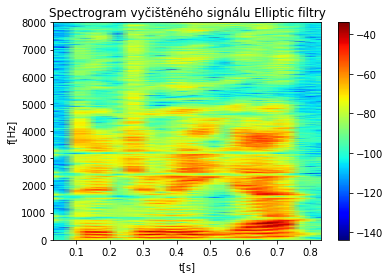

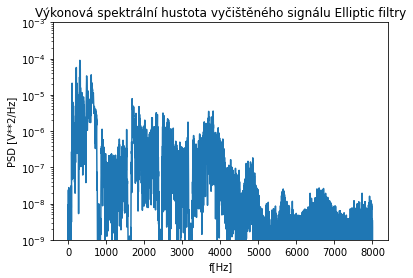

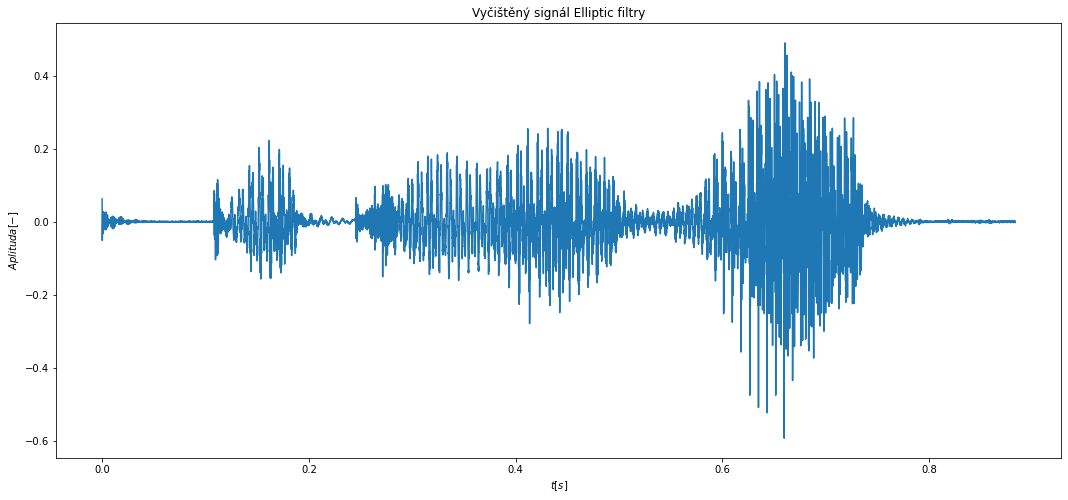

Output before
Stats:
Max: 0.4905700879107312, Min: -0.5936999627355111, Avg: -4.451863022522296e-06, Mean: -4.451863022522296e-06, Med: -2.825554368782628e-05
Output after
Stats:
Max: 0.8263066349496405, Min: -1.0, Avg: -1.1360952343307741e-05, Mean: -5.027899347297623e-19, Med: -4.009408902270854e-05


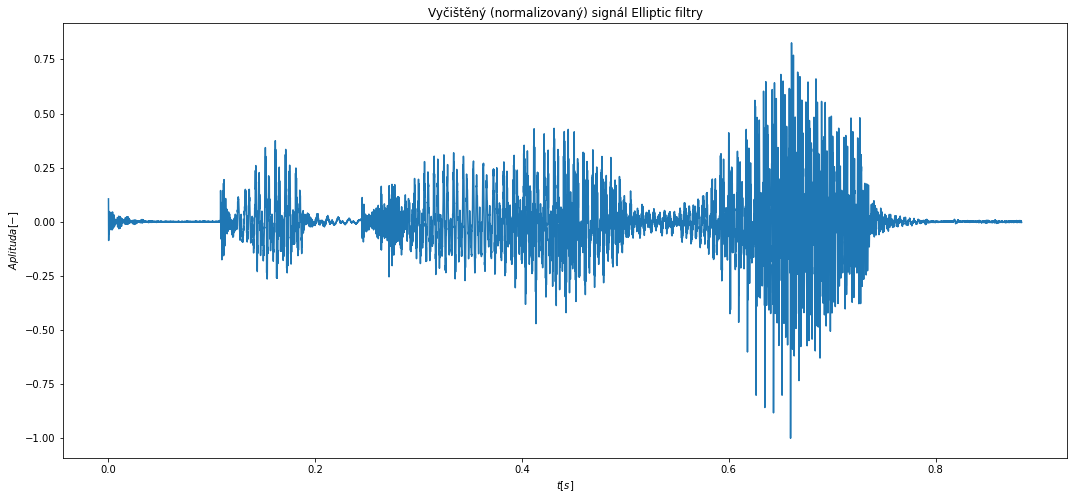

In [104]:
data = samples_normal

for sos in sos_el:
    data = signal.sosfilt(sos, data)

# Spectrogram of cleared signal
f, t, Sxx = signal.spectrogram(data, sample_freq, nperseg=FRAME_SIZE, noverlap=FRAME_OVERLAP)
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='jet')
plt.title("Spectrogram vyčištěného signálu Elliptic filtry")
plt.colorbar()
plt.ylabel('f[Hz]')
plt.xlabel('t[s]')
plt.show()

f, Pxx = signal.periodogram(data, sample_freq, scaling="density")
plt.semilogy(f, Pxx)
plt.title("Výkonová spektrální hustota vyčištěného signálu Elliptic filtry")
plt.ylim([1e-9, 1e-3])
plt.xlabel('f[Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

plt.figure(figsize=(18,8))
plt.title("Vyčištěný signál Elliptic filtry")
plt.plot(np.arange(data.size) / sample_freq, data)
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_ylabel('$Aplituda[-]$')
plt.show()

print("Output before")
print(f"Stats:\nMax: {max(data)}, Min: {min(data)}, Avg: {average(data)}, Mean: {np.mean(data)}, Med: {median(data)}")

data = normalization(data)

print("Output after")
print(f"Stats:\nMax: {max(data)}, Min: {min(data)}, Avg: {average(samples_orig)}, Mean: {np.mean(data)}, Med: {median(data)}")

plt.figure(figsize=(18,8))
plt.title("Vyčištěný (normalizovaný) signál Elliptic filtry")
plt.plot(np.arange(data.size) / sample_freq, data)
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_ylabel('$Aplituda[-]$')
plt.show()

# Save filtered input signal
# wavfile.write("../audio/clean_bandstop.wav", sample_freq, (data * np.iinfo(np.int16).max).astype(np.int16))

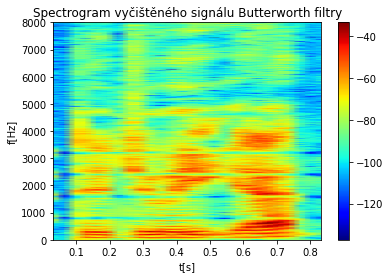

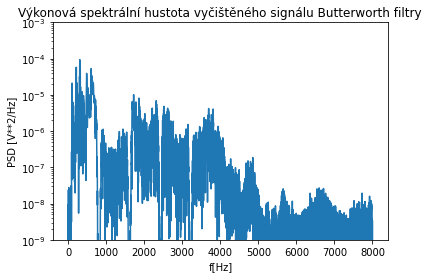

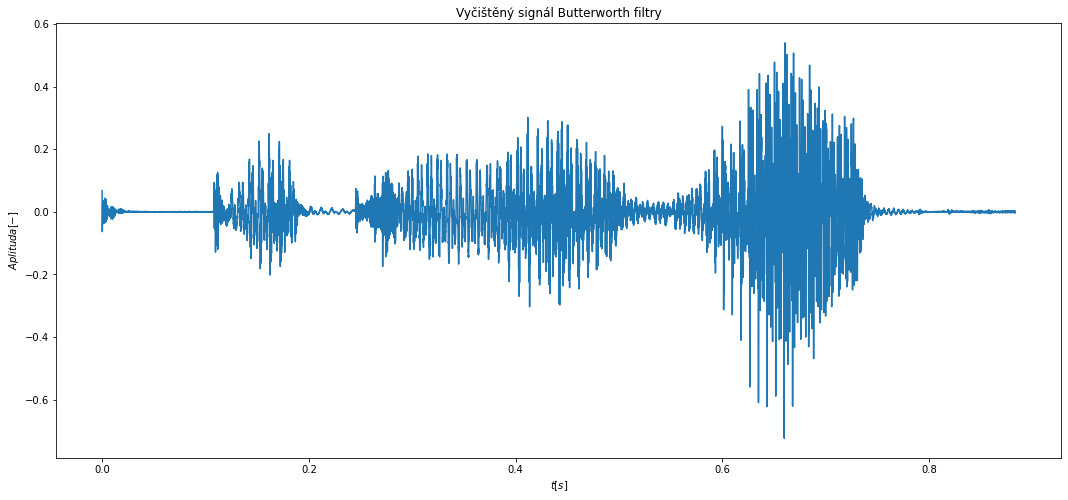

In [105]:
data = samples_normal

for sos in sos_bt:
    data = signal.sosfilt(sos, data)

# Spectrogram of cleared signal
f, t, Sxx = signal.spectrogram(data, sample_freq, nperseg=FRAME_SIZE, noverlap=FRAME_OVERLAP)
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='jet')
plt.title("Spectrogram vyčištěného signálu Butterworth filtry")
plt.colorbar()
plt.ylabel('f[Hz]')
plt.xlabel('t[s]')
plt.show()

f, Pxx = signal.periodogram(data, sample_freq, scaling="density")
plt.semilogy(f, Pxx)
plt.title("Výkonová spektrální hustota vyčištěného signálu Butterworth filtry")
plt.ylim([1e-9, 1e-3])
plt.xlabel('f[Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

plt.figure(figsize=(18,8))
plt.title("Vyčištěný signál Butterworth filtry")
plt.plot(np.arange(data.size) / sample_freq, data)
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_ylabel('$Aplituda[-]$')
plt.show()

wavfile.write("../audio/clean_bandstop.wav", sample_freq, (data * np.iinfo(np.int16).max).astype(np.int16))